In [7]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [154]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [11]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [14]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [16]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Walk Forward Analysis for Target Volatility

In [13]:
start_date = pd.to_datetime('2022-04-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-10-01').date()
WARMUP_DAYS = 285
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 20
slow_mavg = 200
mavg_stepsize = 8
mavg_z_score_window = 126
entry_rolling_donchian_window = 56
exit_rolling_donchian_window = 28
use_donchian_exit_gate = False
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-07-31'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.9
donchian_signal_weight = 0.1
weighted_signal_ewm_window = 4
use_activation = False
tanh_activation_constant_dict = None
rolling_r2_window = 100
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.90
r2_smooth_window = 3
r2_confirm_days = 0
log_std_window = 14
coef_of_variation_window = 20
vol_of_vol_z_score_window = 126
vol_of_vol_p_min = 0.10
r2_strong_threshold = 0.75
use_specific_start_date = True
signal_start_date = pd.Timestamp('2022-04-01').date()

In [133]:
import itertools

def generate_target_volatility_stop_loss_atr_params():
    parameter_grid = {
        "target_volatility": np.arange(0.3, 1.1, 0.1).tolist(),
        "stop_loss_atr": [2]#np.arange(0.75, 3.1, 0.25).tolist()
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [212]:
def run_walk_forward_target_volatility_stop_loss_atr(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'target_volatility', 'stop_loss_atr', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_target_volatility_stop_loss_atr_params():
            print(params)
            target_volatility = params['target_volatility']
            stop_loss_atr = params['stop_loss_atr']
            
            print(target_volatility, stop_loss_atr)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= pd.Timestamp(start_date_is).date()]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = perf.calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        # Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # walk_forward_run_cond = in_sample_cond & date_cond

        # ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        # best_target_volatility = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['target_volatility'].iloc[0]
        # best_stop_loss_atr = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['stop_loss_atr'].iloc[0]
        
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= pd.Timestamp(start_date_os).date()]
                
            print('Calculating Out of Sample Asset Returns!!')
            df_os = perf.calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [214]:
%%time
df_performance_target_volatility_stop_loss_atr_1 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'target_volatility': 0.3, 'stop_loss_atr': 2}
0.3 2
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio

In [215]:
df_performance_target_volatility_stop_loss_atr_1

sampling_category  start_date    end_date  target_volatility  \
0          in_sample  2022-04-01  2023-09-30                0.3   
1         out_sample  2023-10-01  2024-03-31                0.3   
2          in_sample  2022-04-01  2023-09-30                0.4   
3         out_sample  2023-10-01  2024-03-31                0.4   
4          in_sample  2022-04-01  2023-09-30                0.5   
5         out_sample  2023-10-01  2024-03-31                0.5   
6          in_sample  2022-04-01  2023-09-30                0.6   
7         out_sample  2023-10-01  2024-03-31                0.6   
8          in_sample  2022-04-01  2023-09-30                0.7   
9         out_sample  2023-10-01  2024-03-31                0.7   
10         in_sample  2022-04-01  2023-09-30                0.8   
11        out_sample  2023-10-01  2024-03-31                0.8   
12         in_sample  2022-04-01  2023-09-30                0.9   
13        out_sample  2023-10-01  2024-03-31                0.9   
14         in_sample  2022-04-01  2023-09-30                1.0   
15        out_sample  2023-10-01  2024-03-31                1.0   

    stop_loss_atr  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0               2          -0.007785                -0.082063     -0.023833   
1               2           3.265245                 4.564162     31.861014   
2               2          -0.042103                -0.120859     -0.105261   
3               2           5.062797                 4.528530     37.507222   
4               2          -0.074752                -0.152718     -0.164933   
5               2           6.412281                 4.343482     38.271538   
6               2          -0.117362                -0.207682     -0.231006   
7               2           7.314869                 4.216353     39.446661   
8               2          -0.159040                -0.269948     -0.287938   
9               2           7.614356                 4.118735     39.204763   
10              2          -0.181411                -0.292100     -0.314759   
11              2           7.640946                 4.067880     39.194147   
12              2          -0.200447                -0.324611     -0.341915   
13              2           7.552132                 4.035410     38.738578   
14              2          -0.205628                -0.329890     -0.350650   
15              2           7.442854                 4.005673     38.178034   

    annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
0             0.323921     -0.326658              371 days  0.299270   
1             0.325844     -0.102484               46 days  0.519126   
2             0.397764     -0.399985              543 days  0.299270   
3             0.414667     -0.134982               46 days  0.519126   
4             0.455088     -0.453230              543 days  0.301095   
5             0.485075     -0.167547               46 days  0.519126   
6             0.507960     -0.508049              543 days  0.302920   
7             0.535582     -0.185437               48 days  0.519126   
8             0.548006     -0.552342              543 days  0.302920   
9             0.560591     -0.194220               48 days  0.519126   
10            0.573447     -0.576350              543 days  0.301095   
11            0.569634     -0.194951               48 days  0.519126   
12            0.583439     -0.586248              543 days  0.304745   
13            0.571931     -0.194951               48 days  0.519126   
14            0.588177     -0.586418              543 days  0.302920   
15            0.573061     -0.194951               48 days  0.519126   

    t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0      0.124325  0.901104       1045.0                   0.094353   
1      3.340180  0.001016        491.0                   0.219397   
2      0.035298  0.971855       1048.0                   0.104272   
3      3.291619  0

In [216]:
df_performance_target_volatility_stop_loss_atr_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Stop_Loss_ATR_Performance-2022-04-01-2024-04-01.pickle')

In [217]:
%%time
df_performance_target_volatility_stop_loss_atr_2 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'target_volatility': 0.3, 'stop_loss_atr': 2}
0.3 2
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio

In [218]:
df_performance_target_volatility_stop_loss_atr_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Stop_Loss_ATR_Performance-2022-10-01-2024-10-01.pickle')

In [219]:
%%time
df_performance_target_volatility_stop_loss_atr_3 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'target_volatility': 0.3, 'stop_loss_atr': 2}
0.3 2
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio

In [220]:
df_performance_target_volatility_stop_loss_atr_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Stop_Loss_ATR_Performance-2023-04-01-2025-04-01.pickle')

In [221]:
%%time
df_performance_target_volatility_stop_loss_atr_4 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'target_volatility': 0.3, 'stop_loss_atr': 2}
0.3 2
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash 

In [222]:
df_performance_target_volatility_stop_loss_atr_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Stop_Loss_ATR_Performance-2023-10-01-2025-10-01.pickle')

In [232]:
df_performance_target_volatility_stop_loss_atr = pd.concat([df_performance_target_volatility_stop_loss_atr_1, df_performance_target_volatility_stop_loss_atr_2,
                                                            df_performance_target_volatility_stop_loss_atr_3, df_performance_target_volatility_stop_loss_atr_4], axis=0, ignore_index=True)

In [234]:
df_performance_target_volatility_stop_loss_atr.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Stop_Loss_ATR_Performance-2022-04-01-2025-10-01.pickle')

In [236]:
df_performance_target_volatility_stop_loss_atr

sampling_category  start_date    end_date  target_volatility  \
0          in_sample  2022-04-01  2023-09-30                0.3   
1         out_sample  2023-10-01  2024-03-31                0.3   
2          in_sample  2022-04-01  2023-09-30                0.4   
3         out_sample  2023-10-01  2024-03-31                0.4   
4          in_sample  2022-04-01  2023-09-30                0.5   
5         out_sample  2023-10-01  2024-03-31                0.5   
6          in_sample  2022-04-01  2023-09-30                0.6   
7         out_sample  2023-10-01  2024-03-31                0.6   
8          in_sample  2022-04-01  2023-09-30                0.7   
9         out_sample  2023-10-01  2024-03-31                0.7   
10         in_sample  2022-04-01  2023-09-30                0.8   
11        out_sample  2023-10-01  2024-03-31                0.8   
12         in_sample  2022-04-01  2023-09-30                0.9   
13        out_sample  2023-10-01  2024-03-31                0.9   
14         in_sample  2022-04-01  2023-09-30                1.0   
15        out_sample  2023-10-01  2024-03-31                1.0   
16         in_sample  2022-10-01  2024-03-31                0.3   
17        out_sample  2024-04-01  2024-09-30                0.3   
18         in_sample  2022-10-01  2024-03-31                0.4   
19        out_sample  2024-04-01  2024-09-30                0.4   
20         in_sample  2022-10-01  2024-03-31                0.5   
21        out_sample  2024-04-01  2024-09-30                0.5   
22         in_sample  2022-10-01  2024-03-31                0.6   
23        out_sample  2024-04-01  2024-09-30                0.6   
24         in_sample  2022-10-01  2024-03-31                0.7   
25        out_sample  2024-04-01  2024-09-30                0.7   
26         in_sample  2022-10-01  2024-03-31                0.8   
27        out_sample  2024-04-01  2024-09-30                0.8   
28         in_sample  2022-10-01  2024-03-31                0.9   
29        out_sample  2024-04-01  2024-09-30                0.9   
30         in_sample  2022-10-01  2024-03-31                1.0   
31        out_sample  2024-04-01  2024-09-30                1.0   
32         in_sample  2023-04-01  2024-09-30                0.3   
33        out_sample  2024-10-01  2025-03-31                0.3   
34         in_sample  2023-04-01  2024-09-30                0.4   
35        out_sample  2024-10-01  2025-03-31                0.4   
36         in_sample  2023-04-01  2024-09-30                0.5   
37        out_sample  2024-10-01  2025-03-31                0.5   
38         in_sample  2023-04-01  2024-09-30                0.6   
39        out_sample  2024-10-01  2025-03-31                0.6   
40         in_sample  2023-04-01  2024-09-30                0.7   
41        out_sample  2024-10-01  2025-03-31                0.7   
42         in_sample  2023-04-01  2024-09-30                0.8   
43        out_sample  2024-10-01  2025-03-31                0.8   
44         in_sample  2023-04-01  2024-09-30                0.9   
45        out_sample  2024-10-01  2025-03-31                0.9   
46         in_sample  2023-04-01  2024-09-30                1.0   
47        out_sample  2024-10-01  2025-03-31                1.0   
48         in_sample  2023-10-01  2025-03-31                0.3   
49        out_sample  2025-04-01  2025-07-31                0.3   
50         in_sample  2023-10-01  2025-03-31                0.4   
51        out_sample  2025-04-01  2025-07-31                0.4   
52         in_sample  2023-10-01  2025-03-31                0.5   
53        out_sample  2025-04-01  2025-07-31                0.5   
54         in_sample  2023-10-01  2025-03-31                0.6   
55        out_sample  2025-04-01  2025-07-31                0.6   
56         in_sample  2023-10-01  2025-03-31                0.7   
57        out_sample  2025-04-01  2025-07-31                0.7   
58         in_sample  2023-10-01  2025-03-31      

In [238]:
df_performance_target_volatility_stop_loss_atr['vol_tracking_error'] = (np.abs(df_performance_target_volatility_stop_loss_atr['annualized_std_dev'] - df_performance_target_volatility_stop_loss_atr['target_volatility'])/
                                                                       df_performance_target_volatility_stop_loss_atr['target_volatility'])

In [240]:
in_sample_cond = (df_performance_target_volatility_stop_loss_atr.sampling_category == 'in_sample')
df_performance_target_volatility_stop_loss_atr_is = df_performance_target_volatility_stop_loss_atr[in_sample_cond].reset_index(drop=True)
df_performance_target_volatility_stop_loss_atr_os = df_performance_target_volatility_stop_loss_atr[~in_sample_cond].reset_index(drop=True)

In [254]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'annualized_std_dev':['median','mean','std'],
            'vol_tracking_error':['median','mean','std'],
            'trade_count':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}

In [256]:
df_performance_target_volatility_stop_loss_atr_is.groupby(['target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
target_volatility                                               
0.3                              1.798617  1.415624  1.013034   
0.4                              1.818428  1.408951  1.033023   
0.5                              1.752078  1.349157  1.013800   
0.6                              1.730304  1.301222  1.013957   
0.7                              1.703517  1.247243  1.015121   
0.8                              1.685575  1.218691  1.008975   
0.9                              1.657693  1.183648  1.006444   
1.0                              1.632965  1.162098  0.995373   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
target_volatility                                                      
0.3                        0.539738  0.492151  0.373408    -0.172671   
0.4                        0.707046  0.626071  0.488626    -0.224760   
0.5                        0.806364  0.701299  0.561194    -0.267500   
0.6                        0.884099  0.742813  0.609224    -0.295831   
0.7                        0.909165  0.740905  0.628350    -0.311830   
0.8                        0.913986  0.734255  0.636253    -0.317014   
0.9                        0.899195  0.711217  0.630375    -0.320708   
1.0                        0.884976  0.696198  0.622840    -0.321327   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
target_volatility                                                              
0.3               -0.203526  0.084014           0.289029  0.285884  0.045105   
0.4               -0.255329  0.100634           0.363065  0.358073  0.049840   
0.5               -0.300038  0.105901           0.423187  0.415100  0.051111   
0.6               -0.331443  0.123430           0.470527  0.459595  0.057944   
0.7               -0.349894  0.144244           0.496350  0.487050  0.067813   
0.8               -0.356285  0.159646           0.508556  0.501186  0.075998   
0.9               -0.362949  0.161851           0.511725  0.505650  0.079608   
1.0               -0.365071  0.159960           0.513445  0.508045  0.081225   

                  vol_tracking_error                     trade_count           \
                              median      mean       std      median     mean   
target_volatility                                                               
0.3                         0.118664  0.129148  0.057606      1065.0  1102.25   
0.4                         0.093044  0.108320  0.120540      1069.5  1099.75   
0.5                         0.153626  0.169801  0.102222      1067.0  1097.00   
0.6                         0.215789  0.234009  0.096574      1069.5  1103.00   
0.7                         0.290928  0.304215  0.096875      1063.0  1101.00   
0.8                         0.364306  0.373517  0.094997      1073.0  1111.75   
0.9                         0.431417  0.438167  0.088453      1076.0  1115.50   
1.0                         0.486555  0.491955  0.081225      1074.5  1113.25   

                              BTC-USD_annualized_sharpe_ratio            \
                          std                          median      mean   
target_volatility                                                         
0.3                129.685196                        0.384646  0.576742   
0.4                122.355697                        0.402808  0.585591   
0.5                119.498954                        0.439909  0.608247   
0.6                126.039676                        0.470145  0.650179   
0.7                129.524772                        0.486189  0.668028   
0.8                129.288760                        0.511750  0.696283   
0.9                128.958650                        0.521553

In [258]:
df_performance_target_volatility_stop_loss_atr_os.groupby(['target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
target_volatility                                               
0.6                              1.242429  1.463302  2.198085   
0.7                              1.230914  1.437955  2.130764   
0.8                              1.238481  1.436271  2.085125   
0.5                              1.185975  1.427316  2.339894   
0.9                              1.218049  1.419874  2.064700   
0.4                              1.099577  1.413108  2.472449   
1.0                              1.210733  1.408781  2.050975   
0.3                              0.921416  1.298876  2.520086   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
target_volatility                                                      
0.6                        0.429331  2.008158  3.556371    -0.164375   
0.7                        0.435442  2.084660  3.703339    -0.167232   
0.8                        0.447712  2.097737  3.711777    -0.166999   
0.5                        0.391968  1.764225  3.120185    -0.149078   
0.9                        0.446384  2.075120  3.667635    -0.166999   
0.4                        0.353577  1.414818  2.456948    -0.120155   
1.0                        0.451147  2.050181  3.612057    -0.166999   
0.3                        0.248702  0.919324  1.582894    -0.091812   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
target_volatility                                                              
0.6               -0.153012  0.040926           0.503752  0.463684  0.108844   
0.7               -0.156636  0.043754           0.526472  0.484081  0.118008   
0.8               -0.156820  0.043783           0.533603  0.492582  0.121018   
0.5               -0.143375  0.036431           0.440558  0.415346  0.085097   
0.9               -0.156799  0.043820           0.534836  0.495103  0.119164   
0.4               -0.123257  0.026469           0.356578  0.352430  0.055654   
1.0               -0.156703  0.043992           0.535401  0.497694  0.115048   
0.3               -0.095017  0.017217           0.269172  0.274517  0.038933   

                  vol_tracking_error                     trade_count          \
                              median      mean       std      median    mean   
target_volatility                                                              
0.6                         0.160414  0.227193  0.181407       313.0  294.00   
0.7                         0.247897  0.308456  0.168583       308.5  291.50   
0.8                         0.332996  0.384272  0.151272       304.5  292.00   
0.5                         0.118885  0.169308  0.170193       308.5  291.25   
0.9                         0.405737  0.449886  0.132404       304.0  293.25   
0.4                         0.108555  0.137257  0.114440       315.0  293.25   
1.0                         0.464599  0.502306  0.115048       305.5  294.00   
0.3                         0.111297  0.128017  0.067907       318.0  294.25   

                              BTC-USD_annualized_sharpe_ratio            \
                          std                          median      mean   
target_volatility                                                         
0.6                198.284308                        1.130718  0.628241   
0.7                198.246480                        1.134827  0.640485   
0.8                200.640641                        1.146097  0.669207   
0.5                195.322596                        1.044262  0.555692   
0.9                200.629634                        1.146291  0.673581   
0.4                194.958756                        0.952385  0.477428   
1.0                200.314752                        1.146322  0.673602 

In [252]:
df_performance_target_volatility_stop_loss_atr_os.groupby(['start_date','target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                \
                                              median      mean std   
start_date target_volatility                                         
2023-10-01 0.3                              4.564162  4.564162 NaN   
           0.4                              4.528530  4.528530 NaN   
           0.5                              4.343482  4.343482 NaN   
           0.6                              4.216353  4.216353 NaN   
           0.7                              4.118735  4.118735 NaN   
           0.8                              4.067880  4.067880 NaN   
           0.9                              4.035410  4.035410 NaN   
           1.0                              4.005673  4.005673 NaN   
2025-04-01 0.4                              2.158965  2.158965 NaN   
           0.5                              2.156270  2.156270 NaN   
           0.6                              2.101423  2.101423 NaN   
           0.7                              2.008809  2.008809 NaN   
           0.8                              1.959526  1.959526 NaN   
           0.9                              1.915911  1.915911 NaN   
           1.0                              1.901278  1.901278 NaN   
           0.3                              1.871024  1.871024 NaN   
2024-10-01 1.0                              0.520188  0.520188 NaN   
           0.9                              0.520188  0.520188 NaN   
           0.8                              0.517436  0.517436 NaN   
           0.7                              0.453019  0.453019 NaN   
           0.6                              0.383434  0.383434 NaN   
           0.5                              0.215679  0.215679 NaN   
           0.4                              0.040189  0.040189 NaN   
           0.3                             -0.028192 -0.028192 NaN   
2024-04-01 0.9                             -0.792014 -0.792014 NaN   
           1.0                             -0.792014 -0.792014 NaN   
           0.8                             -0.799757 -0.799757 NaN   
           0.7                             -0.828742 -0.828742 NaN   
           0.6                             -0.848001 -0.848001 NaN   
           0.5                             -1.006168 -1.006168 NaN   
           0.4                             -1.075253 -1.075253 NaN   
           0.3                             -1.211492 -1.211492 NaN   

                             annualized_return               max_drawdown  \
                                        median      mean std       median   
start_date target_volatility                                                
2023-10-01 0.3                        3.265245  3.265245 NaN    -0.102484   
           0.4                        5.062797  5.062797 NaN    -0.134982   
           0.5                        6.412281  6.412281 NaN    -0.167547   
           0.6                        7.314869  7.314869 NaN    -0.185437   
           0.7                        7.614356  7.614356 NaN    -0.194220   
           0.8                        7.640946  7.640946 NaN    -0.194951   
           0.9                        7.552132  7.552132 NaN    -0.194951   
           1.0                        7.442854  7.442854 NaN    -0.194951   
2025-04-01 0.4                        0.687070  0.687070 NaN    -0.097866   
           0.5                        0.718000  0.718000 NaN    -0.097864   
           0.6                        0.727909  0.727909 NaN    -0.097863   
           0.7                        0.707708  0.707708 NaN    -0.097861   
           0.8                        0.700466  0.700466 NaN    -0.098328   
           0.9                        0.696428  0.696428 NaN    -0.098245   
           1.0                        0.705954  0.705954 NaN    -0.097860   
           0.3                        0.477256  0.477256 NaN    -0.080609   
2024-10-01 1.0                        0.196339  0.196339 NaN    -0.185281   
           0.9                        

In [250]:
df_performance_target_volatility_stop_loss_atr_os[df_performance_target_volatility_stop_loss_atr_os.start_date == pd.Timestamp('2025-04-01').date()]

sampling_category  start_date    end_date  target_volatility  \
24        out_sample  2025-04-01  2025-07-31                0.3   
25        out_sample  2025-04-01  2025-07-31                0.4   
26        out_sample  2025-04-01  2025-07-31                0.5   
27        out_sample  2025-04-01  2025-07-31                0.6   
28        out_sample  2025-04-01  2025-07-31                0.7   
29        out_sample  2025-04-01  2025-07-31                0.8   
30        out_sample  2025-04-01  2025-07-31                0.9   
31        out_sample  2025-04-01  2025-07-31                1.0   

    stop_loss_atr  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
24              2           0.477256                 1.871024      5.920640   
25              2           0.687070                 2.158965      7.020500   
26              2           0.718000                 2.156270      7.336686   
27              2           0.727909                 2.101423      7.438077   
28              2           0.707708                 2.008809      7.231795   
29              2           0.700466                 1.959526      7.123774   
30              2           0.696428                 1.915911      7.088699   
31              2           0.705954                 1.901278      7.213894   

    annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
24            0.233879     -0.080609               39 days  0.401639   
25            0.281899     -0.097866               39 days  0.409836   
26            0.295194     -0.097864               39 days  0.409836   
27            0.307227     -0.097863               39 days  0.409836   
28            0.314683     -0.097861               39 days  0.409836   
29            0.320015     -0.098328               56 days  0.418033   
30            0.325884     -0.098245               56 days  0.418033   
31            0.335118     -0.097860               39 days  0.418033   

    t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
24     1.228405  0.221679        247.0                   0.177058   
25     1.369743  0.173304        234.0                   0.250691   
26     1.363266  0.175330        231.0                   0.259156   
27     1.326820  0.187067        231.0                   0.259693   
28     1.270421  0.206372        230.0                   0.260174   
29     1.239859  0.217427        230.0                   0.260263   
30     1.212446  0.227704        229.0                   0.260271   
31     1.201754  0.231806        232.0                   0.260284   

    ETH-USD_annualized_return  SOL-USD_annualized_return  \
24                   0.334362                   0.045059   
25                   0.417817                   0.063363   
26                   0.410480                   0.086877   
27                   0.401150                   0.110643   
28                   0.391858                   0.111644   
29                   0.391183                   0.108116   
30                   0.392073                   0.104629   
31                   0.408407                   0.101720   

    ADA-USD_annualized_return  AVAX-USD_annualized_return  \
24                        0.0                   -0.000530   
25                        0.0                   -0.000707   
26                        0.0                   -0.000884   
27                        0.0                   -0.001061   
28                        0.0                   -0.001652   
29                        0.0                   -0.001897   
30                        0.0                   -0.002135   
31                        0.0                   -0.002360   

    BTC-USD_annualized_sharpe_ratio  ETH-USD_annualized_sharpe_ratio  \
24                         0.916524                         2.889545   
25                         1.186656                         2.998402   
26                         1.224417                         2.752985   
27                         1.226099  

In [109]:
df_performance_target_volatility_stop_loss_atr.sort_values('annualized_sharpe_ratio', ascending=False)

sampling_category  start_date    end_date  target_volatility  \
80         out_sample  2023-10-01  2024-03-31                0.3   
82          in_sample  2022-10-01  2024-03-31                0.3   
85          in_sample  2022-10-01  2024-03-31                0.3   
92          in_sample  2022-10-01  2024-03-31                0.4   
95          in_sample  2022-10-01  2024-03-31                0.4   
87          in_sample  2022-10-01  2024-03-31                0.3   
86          in_sample  2022-10-01  2024-03-31                0.3   
88          in_sample  2022-10-01  2024-03-31                0.3   
89          in_sample  2022-10-01  2024-03-31                0.3   
102         in_sample  2022-10-01  2024-03-31                0.5   
90          in_sample  2022-10-01  2024-03-31                0.3   
105         in_sample  2022-10-01  2024-03-31                0.5   
97          in_sample  2022-10-01  2024-03-31                0.4   
96          in_sample  2022-10-01  2024-03-31                0.4   
98          in_sample  2022-10-01  2024-03-31                0.4   
84          in_sample  2022-10-01  2024-03-31                0.3   
99          in_sample  2022-10-01  2024-03-31                0.4   
100         in_sample  2022-10-01  2024-03-31                0.4   
112         in_sample  2022-10-01  2024-03-31                0.6   
94          in_sample  2022-10-01  2024-03-31                0.4   
83          in_sample  2022-10-01  2024-03-31                0.3   
115         in_sample  2022-10-01  2024-03-31                0.6   
107         in_sample  2022-10-01  2024-03-31                0.5   
122         in_sample  2022-10-01  2024-03-31                0.7   
106         in_sample  2022-10-01  2024-03-31                0.5   
108         in_sample  2022-10-01  2024-03-31                0.5   
109         in_sample  2022-10-01  2024-03-31                0.5   
93          in_sample  2022-10-01  2024-03-31                0.4   
110         in_sample  2022-10-01  2024-03-31                0.5   
132         in_sample  2022-10-01  2024-03-31                0.8   
104         in_sample  2022-10-01  2024-03-31                0.5   
142         in_sample  2022-10-01  2024-03-31                0.9   
125         in_sample  2022-10-01  2024-03-31                0.7   
103         in_sample  2022-10-01  2024-03-31                0.5   
117         in_sample  2022-10-01  2024-03-31                0.6   
116         in_sample  2022-10-01  2024-03-31                0.6   
118         in_sample  2022-10-01  2024-03-31                0.6   
119         in_sample  2022-10-01  2024-03-31                0.6   
178         in_sample  2023-04-01  2024-09-30                0.4   
120         in_sample  2022-10-01  2024-03-31                0.6   
176         in_sample  2023-04-01  2024-09-30                0.4   
114         in_sample  2022-10-01  2024-03-31                0.6   
179         in_sample  2023-04-01  2024-09-30                0.4   
181         in_sample  2023-04-01  2024-09-30                0.4   
180         in_sample  2023-04-01  2024-09-30                0.4   
135         in_sample  2022-10-01  2024-03-31                0.8   
152         in_sample  2022-10-01  2024-03-31                1.0   
177         in_sample  2023-04-01  2024-09-30                0.4   
175         in_sample  2023-04-01  2024-09-30                0.4   
113         in_sample  2022-10-01  2024-03-31                0.6   
145         in_sample  2022-10-01  2024-03-31                0.9   
188         in_sample  2023-04-01  2024-09-30                0.5   
166         in_sample  2023-04-01  2024-09-30                0.3   
168         in_sample  2023-04-01  2024-09-30                0.3   
81          in_sample  2022-10-01  2024-03-31                0.3   
323        out_sample  2025-04-01  2025-07-31                0.3   
189         in_sample  2023-04-01  2024-09-30                0.5   
190         in_sample  2023-04-01  2024-09-30               

## Walk Forward Analysis for Target Volatility Micro Grid

In [265]:
np.arange(0.4, 0.75, 0.05).tolist()

[0.4, 0.45, 0.5, 0.55, 0.6, 0.6499999999999999, 0.7]

In [267]:
import itertools

def generate_target_volatility_stop_loss_atr_params():
    parameter_grid = {
        "target_volatility": np.arange(0.4, 0.75, 0.05).tolist(),
        "stop_loss_atr": [2]#np.arange(0.75, 3.1, 0.25).tolist()
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [331]:
def run_walk_forward_target_volatility_stop_loss_atr(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'target_volatility', 'stop_loss_atr', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_target_volatility_stop_loss_atr_params():
            print(params)
            target_volatility = params['target_volatility']
            stop_loss_atr = params['stop_loss_atr']
            
            print(target_volatility, stop_loss_atr)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= pd.Timestamp(start_date_is).date()]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = perf.calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        # Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # walk_forward_run_cond = in_sample_cond & date_cond

        # ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        # best_target_volatility = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['target_volatility'].iloc[0]
        # best_stop_loss_atr = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['stop_loss_atr'].iloc[0]
        
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= pd.Timestamp(start_date_os).date()]
                
            print('Calculating Out of Sample Asset Returns!!')
            df_os = perf.calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [333]:
%%time
df_performance_target_volatility_micro_1 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'target_volatility': 0.4, 'stop_loss_atr': 2}
0.4 2
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio

In [334]:
df_performance_target_volatility_micro_1

sampling_category  start_date    end_date  target_volatility  \
0          in_sample  2022-04-01  2023-09-30               0.40   
1         out_sample  2023-10-01  2024-03-31               0.40   
2          in_sample  2022-04-01  2023-09-30               0.45   
3         out_sample  2023-10-01  2024-03-31               0.45   
4          in_sample  2022-04-01  2023-09-30               0.50   
5         out_sample  2023-10-01  2024-03-31               0.50   
6          in_sample  2022-04-01  2023-09-30               0.55   
7         out_sample  2023-10-01  2024-03-31               0.55   
8          in_sample  2022-04-01  2023-09-30               0.60   
9         out_sample  2023-10-01  2024-03-31               0.60   
10         in_sample  2022-04-01  2023-09-30               0.65   
11        out_sample  2023-10-01  2024-03-31               0.65   
12         in_sample  2022-04-01  2023-09-30               0.70   
13        out_sample  2023-10-01  2024-03-31               0.70   

    stop_loss_atr  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0               2          -0.042103                -0.120859     -0.105261   
1               2           5.062797                 4.528530     37.507222   
2               2          -0.050502                -0.111321     -0.119184   
3               2           5.824276                 4.459586     38.589493   
4               2          -0.074752                -0.152718     -0.164933   
5               2           6.412281                 4.343482     38.271538   
6               2          -0.097338                -0.184626     -0.201887   
7               2           6.977381                 4.271527     39.165265   
8               2          -0.117362                -0.207682     -0.231006   
9               2           7.314869                 4.216353     39.446661   
10              2          -0.135775                -0.230018     -0.256556   
11              2           7.535787                 4.171656     39.466385   
12              2          -0.159040                -0.269948     -0.287938   
13              2           7.614356                 4.118735     39.204763   

    annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
0             0.397764     -0.399985              543 days  0.299270   
1             0.414667     -0.134982               46 days  0.519126   
2             0.429003     -0.423735              543 days  0.297445   
3             0.450482     -0.150929               46 days  0.519126   
4             0.455088     -0.453230              543 days  0.301095   
5             0.485075     -0.167547               46 days  0.519126   
6             0.482503     -0.482143              543 days  0.299270   
7             0.515147     -0.178152               48 days  0.519126   
8             0.507960     -0.508049              543 days  0.302920   
9             0.535582     -0.185437               48 days  0.519126   
10            0.531630     -0.529224              543 days  0.302920   
11            0.549779     -0.190942               48 days  0.519126   
12            0.548006     -0.552342              543 days  0.302920   
13            0.560591     -0.194220               48 days  0.519126   

    t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0      0.035298  0.971855       1048.0                   0.104272   
1      3.291619  0.001196        494.0                   0.245218   
2      0.033085  0.973619       1039.0                   0.116199   
3      3.235811  0.001441        493.0                   0.258946   
4     -0.027552  0.978029       1043.0                   0.110630   
5      3.147942  0.001922        499.0                   0.273771   
6     -0.075661  0.939716       1042.0                   0.107885   
7      3.092902  0.002294        494.0                   0.289048   
8     -0.111688  0.911112       1038.0                   0.107388   
9      3.051391  0.002619        502.0  

In [337]:
df_performance_target_volatility_micro_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Micro_Grid_Performance-2022-04-01-2024-04-01.pickle')

In [339]:
%%time
df_performance_target_volatility_micro_2 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'target_volatility': 0.4, 'stop_loss_atr': 2}
0.4 2
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio

In [341]:
df_performance_target_volatility_micro_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Micro_Grid_Performance-2022-10-01-2024-10-01.pickle')

In [343]:
%%time
df_performance_target_volatility_micro_3 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'target_volatility': 0.4, 'stop_loss_atr': 2}
0.4 2
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio

In [ ]:
df_performance_target_volatility_micro_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Micro_Grid_Performance-2023-04-01-2025-04-01.pickle')

In [345]:
%%time
df_performance_target_volatility_micro_4 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'target_volatility': 0.4, 'stop_loss_atr': 2}
0.4 2
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash 

In [346]:
df_performance_target_volatility_micro_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Micro_Grid_Performance-2023-10-01-2025-10-01.pickle')

In [349]:
df_performance_target_volatility_micro = pd.concat([df_performance_target_volatility_micro_1, df_performance_target_volatility_micro_2,
                                                    df_performance_target_volatility_micro_3, df_performance_target_volatility_micro_4], axis=0, ignore_index=True)

In [353]:
df_performance_target_volatility_micro.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_Micro_Grid_Performance-2022-04-01-2025-10-01.pickle')

In [355]:
df_performance_target_volatility_micro['vol_tracking_error'] = (np.abs(df_performance_target_volatility_micro['annualized_std_dev'] - df_performance_target_volatility_micro['target_volatility'])/
                                                                df_performance_target_volatility_micro['target_volatility'])

In [357]:
in_sample_cond = (df_performance_target_volatility_micro.sampling_category == 'in_sample')
df_performance_target_volatility_micro_is = df_performance_target_volatility_micro[in_sample_cond].reset_index(drop=True)
df_performance_target_volatility_micro_os = df_performance_target_volatility_micro[~in_sample_cond].reset_index(drop=True)

In [359]:
df_performance_target_volatility_micro

sampling_category  start_date    end_date  target_volatility  \
0          in_sample  2022-04-01  2023-09-30               0.40   
1         out_sample  2023-10-01  2024-03-31               0.40   
2          in_sample  2022-04-01  2023-09-30               0.45   
3         out_sample  2023-10-01  2024-03-31               0.45   
4          in_sample  2022-04-01  2023-09-30               0.50   
5         out_sample  2023-10-01  2024-03-31               0.50   
6          in_sample  2022-04-01  2023-09-30               0.55   
7         out_sample  2023-10-01  2024-03-31               0.55   
8          in_sample  2022-04-01  2023-09-30               0.60   
9         out_sample  2023-10-01  2024-03-31               0.60   
10         in_sample  2022-04-01  2023-09-30               0.65   
11        out_sample  2023-10-01  2024-03-31               0.65   
12         in_sample  2022-04-01  2023-09-30               0.70   
13        out_sample  2023-10-01  2024-03-31               0.70   
14         in_sample  2022-10-01  2024-03-31               0.40   
15        out_sample  2024-04-01  2024-09-30               0.40   
16         in_sample  2022-10-01  2024-03-31               0.45   
17        out_sample  2024-04-01  2024-09-30               0.45   
18         in_sample  2022-10-01  2024-03-31               0.50   
19        out_sample  2024-04-01  2024-09-30               0.50   
20         in_sample  2022-10-01  2024-03-31               0.55   
21        out_sample  2024-04-01  2024-09-30               0.55   
22         in_sample  2022-10-01  2024-03-31               0.60   
23        out_sample  2024-04-01  2024-09-30               0.60   
24         in_sample  2022-10-01  2024-03-31               0.65   
25        out_sample  2024-04-01  2024-09-30               0.65   
26         in_sample  2022-10-01  2024-03-31               0.70   
27        out_sample  2024-04-01  2024-09-30               0.70   
28         in_sample  2023-04-01  2024-09-30               0.40   
29        out_sample  2024-10-01  2025-03-31               0.40   
30         in_sample  2023-04-01  2024-09-30               0.45   
31        out_sample  2024-10-01  2025-03-31               0.45   
32         in_sample  2023-04-01  2024-09-30               0.50   
33        out_sample  2024-10-01  2025-03-31               0.50   
34         in_sample  2023-04-01  2024-09-30               0.55   
35        out_sample  2024-10-01  2025-03-31               0.55   
36         in_sample  2023-04-01  2024-09-30               0.60   
37        out_sample  2024-10-01  2025-03-31               0.60   
38         in_sample  2023-04-01  2024-09-30               0.65   
39        out_sample  2024-10-01  2025-03-31               0.65   
40         in_sample  2023-04-01  2024-09-30               0.70   
41        out_sample  2024-10-01  2025-03-31               0.70   
42         in_sample  2023-10-01  2025-03-31               0.40   
43        out_sample  2025-04-01  2025-07-31               0.40   
44         in_sample  2023-10-01  2025-03-31               0.45   
45        out_sample  2025-04-01  2025-07-31               0.45   
46         in_sample  2023-10-01  2025-03-31               0.50   
47        out_sample  2025-04-01  2025-07-31               0.50   
48         in_sample  2023-10-01  2025-03-31               0.55   
49        out_sample  2025-04-01  2025-07-31               0.55   
50         in_sample  2023-10-01  2025-03-31               0.60   
51        out_sample  2025-04-01  2025-07-31               0.60   
52         in_sample  2023-10-01  2025-03-31               0.65   
53        out_sample  2025-04-01  2025-07-31               0.65   
54         in_sample  2023-10-01  2025-03-31               0.70   
55        out_sample  2025-04-01  2025-07-31               0.70   

    stop_loss_atr  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0               2          -0.042103                -0.120859     -0.105261   
1               2        

In [363]:
df_performance_target_volatility_micro_os#.groupby(['start_date']).size()

sampling_category  start_date    end_date  target_volatility  \
0         out_sample  2023-10-01  2024-03-31               0.40   
1         out_sample  2023-10-01  2024-03-31               0.45   
2         out_sample  2023-10-01  2024-03-31               0.50   
3         out_sample  2023-10-01  2024-03-31               0.55   
4         out_sample  2023-10-01  2024-03-31               0.60   
5         out_sample  2023-10-01  2024-03-31               0.65   
6         out_sample  2023-10-01  2024-03-31               0.70   
7         out_sample  2024-04-01  2024-09-30               0.40   
8         out_sample  2024-04-01  2024-09-30               0.45   
9         out_sample  2024-04-01  2024-09-30               0.50   
10        out_sample  2024-04-01  2024-09-30               0.55   
11        out_sample  2024-04-01  2024-09-30               0.60   
12        out_sample  2024-04-01  2024-09-30               0.65   
13        out_sample  2024-04-01  2024-09-30               0.70   
14        out_sample  2024-10-01  2025-03-31               0.40   
15        out_sample  2024-10-01  2025-03-31               0.45   
16        out_sample  2024-10-01  2025-03-31               0.50   
17        out_sample  2024-10-01  2025-03-31               0.55   
18        out_sample  2024-10-01  2025-03-31               0.60   
19        out_sample  2024-10-01  2025-03-31               0.65   
20        out_sample  2024-10-01  2025-03-31               0.70   
21        out_sample  2025-04-01  2025-07-31               0.40   
22        out_sample  2025-04-01  2025-07-31               0.45   
23        out_sample  2025-04-01  2025-07-31               0.50   
24        out_sample  2025-04-01  2025-07-31               0.55   
25        out_sample  2025-04-01  2025-07-31               0.60   
26        out_sample  2025-04-01  2025-07-31               0.65   
27        out_sample  2025-04-01  2025-07-31               0.70   

    stop_loss_atr  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0               2           5.062797                 4.528530     37.507222   
1               2           5.824276                 4.459586     38.589493   
2               2           6.412281                 4.343482     38.271538   
3               2           6.977381                 4.271527     39.165265   
4               2           7.314869                 4.216353     39.446661   
5               2           7.535787                 4.171656     39.466385   
6               2           7.614356                 4.118735     39.204763   
7               2          -0.110678                -1.075253     -1.050781   
8               2          -0.124961                -1.036947     -1.058811   
9               2          -0.139316                -1.006168     -1.066668   
10              2          -0.146856                -0.946110     -1.036972   
11              2          -0.140901                -0.848001     -0.964942   
12              2          -0.141234                -0.820877     -0.957737   
13              2          -0.146600                -0.828742     -0.982682   
14              2           0.020084                 0.040189      0.129701   
15              2           0.035715                 0.114898      0.209732   
16              2           0.065935                 0.215679      0.371505   
17              2           0.114402                 0.344472      0.643819   
18              2           0.130753                 0.383434      0.715554   
19              2           0.147865                 0.420932      0.800019   
20              2           0.163176                 0.453019      0.880699   
21              2           0.687070                 2.158965      7.020500   
22              2           0.713115                 2.181295      7.286694   
23              2           0.718000                 2.156270      7.336686   
24              2           0.722969                 2.129599      7.387525   
25   

In [365]:
df_performance_target_volatility_micro_is.groupby(['target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
target_volatility                                               
0.40                             1.818428  1.408951  1.033023   
0.45                             1.799051  1.397682  1.019965   
0.50                             1.752078  1.349157  1.013800   
0.55                             1.742953  1.325141  1.016352   
0.60                             1.730304  1.301222  1.013957   
0.65                             1.723027  1.281294  1.013302   
0.70                             1.703517  1.247243  1.015121   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
target_volatility                                                      
0.40                       0.707046  0.626071  0.488626    -0.224760   
0.45                       0.768161  0.678208  0.531959    -0.246122   
0.50                       0.806364  0.701299  0.561194    -0.267500   
0.55                       0.855210  0.729475  0.590560    -0.284786   
0.60                       0.884099  0.742813  0.609224    -0.295831   
0.65                       0.905154  0.750068  0.622976    -0.303524   
0.70                       0.909165  0.740905  0.628350    -0.311830   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
target_volatility                                                              
0.40              -0.255329  0.100634           0.363065  0.358073  0.049840   
0.45              -0.276904  0.101946           0.394748  0.387966  0.051166   
0.50              -0.300038  0.105901           0.423187  0.415100  0.051111   
0.55              -0.318714  0.113288           0.450029  0.439708  0.053336   
0.60              -0.331443  0.123430           0.470527  0.459595  0.057944   
0.65              -0.340456  0.133075           0.483910  0.474946  0.063497   
0.70              -0.349894  0.144244           0.496350  0.487050  0.067813   

                  vol_tracking_error                     trade_count           \
                              median      mean       std      median     mean   
target_volatility                                                               
0.40                        0.093044  0.108320  0.120540      1069.5  1099.75   
0.45                        0.122782  0.137852  0.113703      1066.5  1098.00   
0.50                        0.153626  0.169801  0.102222      1067.0  1097.00   
0.55                        0.181766  0.200530  0.096975      1070.0  1098.75   
0.60                        0.215789  0.234009  0.096574      1069.5  1103.00   
0.65                        0.255523  0.269314  0.097687      1069.0  1104.75   
0.70                        0.290928  0.304215  0.096875      1063.0  1101.00   

                              BTC-USD_annualized_sharpe_ratio            \
                          std                          median      mean   
target_volatility                                                         
0.40               122.355697                        0.402808  0.585591   
0.45               123.954293                        0.441088  0.617039   
0.50               119.498954                        0.439909  0.608247   
0.55               122.363870                        0.453268  0.624454   
0.60               126.039676                        0.470145  0.650179   
0.65               128.621862                        0.478718  0.662633   
0.70               129.524772                        0.486189  0.668028   

                            ETH-USD_annualized_sharpe_ratio            \
                        std                          median      mean   
target_volatility                                                       
0.40               0.651611                        1.148339  0.8

In [367]:
df_performance_target_volatility_micro_os.groupby(['target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
target_volatility                                               
0.60                             1.242429  1.463302  2.198085   
0.65                             1.235831  1.455610  2.159014   
0.55                             1.237036  1.449872  2.264686   
0.70                             1.230914  1.437955  2.130764   
0.45                             1.148097  1.429708  2.419239   
0.50                             1.185975  1.427316  2.339894   
0.40                             1.099577  1.413108  2.472449   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
target_volatility                                                      
0.60                       0.429331  2.008158  3.556371    -0.164375   
0.65                       0.432322  2.064799  3.664700    -0.166147   
0.55                       0.418685  1.916974  3.393230    -0.159656   
0.70                       0.435442  2.084660  3.703339    -0.167232   
0.45                       0.374415  1.612036  2.831547    -0.134475   
0.50                       0.391968  1.764225  3.120185    -0.149078   
0.40                       0.353577  1.414818  2.456948    -0.120155   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
target_volatility                                                              
0.60              -0.153012  0.040926           0.503752  0.463684  0.108844   
0.65              -0.155274  0.042828           0.517635  0.475658  0.114166   
0.55              -0.148832  0.038046           0.478094  0.443086  0.099613   
0.70              -0.156636  0.043754           0.526472  0.484081  0.118008   
0.45              -0.134275  0.032476           0.399743  0.384497  0.070168   
0.50              -0.143375  0.036431           0.440558  0.415346  0.085097   
0.40              -0.123257  0.026469           0.356578  0.352430  0.055654   

                  vol_tracking_error                     trade_count          \
                              median      mean       std      median    mean   
target_volatility                                                              
0.60                        0.160414  0.227193  0.181407       313.0  294.00   
0.65                        0.203638  0.268218  0.175639       313.0  294.25   
0.55                        0.130739  0.194389  0.181114       310.5  290.75   
0.70                        0.247897  0.308456  0.168583       308.5  291.50   
0.45                        0.111682  0.146098  0.155259       314.0  292.50   
0.50                        0.118885  0.169308  0.170193       308.5  291.25   
0.40                        0.108555  0.137257  0.114440       315.0  293.25   

                              BTC-USD_annualized_sharpe_ratio            \
                          std                          median      mean   
target_volatility                                                         
0.60               198.284308                        1.130718  0.628241   
0.65               199.673692                        1.133329  0.636995   
0.55               194.643906                        1.108872  0.599098   
0.70               198.246480                        1.134827  0.640485   
0.45               195.102537                        0.994829  0.520723   
0.50               195.322596                        1.044262  0.555692   
0.40               194.958756                        0.952385  0.477428   

                            ETH-USD_annualized_sharpe_ratio            \
                        std                          median      mean   
target_volatility                                                       
0.60               1.083327                        0.882104  0.459261   
0

## Walk Forward Analysis with Target Volatility, ATR Multiple and ATR Window

In [374]:
import itertools

def generate_target_volatility_stop_loss_atr_params():
    parameter_grid = {
        "target_volatility": [0.5, 0.55, 0.60],
        "stop_loss_atr": np.arange(0.75, 3.1, 0.25).tolist(),
        "atr_window": [10, 14, 20, 30]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [380]:
def run_walk_forward_target_volatility_stop_loss_atr(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'target_volatility', 'stop_loss_atr', 'atr_window', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_target_volatility_stop_loss_atr_params():
            print(params)
            target_volatility = params['target_volatility']
            stop_loss_atr = params['stop_loss_atr']
            atr_window = params['atr_window']
            
            print(target_volatility, stop_loss_atr, atr_window)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= pd.Timestamp(start_date_is).date()]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = perf.calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr,
                'atr_window': atr_window
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        # Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # walk_forward_run_cond = in_sample_cond & date_cond

        # ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        # best_target_volatility = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['target_volatility'].iloc[0]
        # best_stop_loss_atr = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['stop_loss_atr'].iloc[0]
        
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= pd.Timestamp(start_date_os).date()]
                
            print('Calculating Out of Sample Asset Returns!!')
            df_os = perf.calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr,
                'atr_window': atr_window
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [382]:
%%time
df_performance_target_volatility_atr_1 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'target_volatility': 0.5, 'stop_loss_atr': 0.75, 'atr_window': 10}
0.5 0.75 10
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Managem

In [383]:
df_performance_target_volatility_atr_1

sampling_category  start_date    end_date  target_volatility  \
0           in_sample  2022-04-01  2023-09-30               0.50   
1          out_sample  2023-10-01  2024-03-31               0.50   
2           in_sample  2022-04-01  2023-09-30               0.50   
3          out_sample  2023-10-01  2024-03-31               0.50   
4           in_sample  2022-04-01  2023-09-30               0.50   
5          out_sample  2023-10-01  2024-03-31               0.50   
6           in_sample  2022-04-01  2023-09-30               0.50   
7          out_sample  2023-10-01  2024-03-31               0.50   
8           in_sample  2022-04-01  2023-09-30               0.50   
9          out_sample  2023-10-01  2024-03-31               0.50   
10          in_sample  2022-04-01  2023-09-30               0.50   
11         out_sample  2023-10-01  2024-03-31               0.50   
12          in_sample  2022-04-01  2023-09-30               0.50   
13         out_sample  2023-10-01  2024-03-31               0.50   
14          in_sample  2022-04-01  2023-09-30               0.50   
15         out_sample  2023-10-01  2024-03-31               0.50   
16          in_sample  2022-04-01  2023-09-30               0.50   
17         out_sample  2023-10-01  2024-03-31               0.50   
18          in_sample  2022-04-01  2023-09-30               0.50   
19         out_sample  2023-10-01  2024-03-31               0.50   
20          in_sample  2022-04-01  2023-09-30               0.50   
21         out_sample  2023-10-01  2024-03-31               0.50   
22          in_sample  2022-04-01  2023-09-30               0.50   
23         out_sample  2023-10-01  2024-03-31               0.50   
24          in_sample  2022-04-01  2023-09-30               0.50   
25         out_sample  2023-10-01  2024-03-31               0.50   
26          in_sample  2022-04-01  2023-09-30               0.50   
27         out_sample  2023-10-01  2024-03-31               0.50   
28          in_sample  2022-04-01  2023-09-30               0.50   
29         out_sample  2023-10-01  2024-03-31               0.50   
30          in_sample  2022-04-01  2023-09-30               0.50   
31         out_sample  2023-10-01  2024-03-31               0.50   
32          in_sample  2022-04-01  2023-09-30               0.50   
33         out_sample  2023-10-01  2024-03-31               0.50   
34          in_sample  2022-04-01  2023-09-30               0.50   
35         out_sample  2023-10-01  2024-03-31               0.50   
36          in_sample  2022-04-01  2023-09-30               0.50   
37         out_sample  2023-10-01  2024-03-31               0.50   
38          in_sample  2022-04-01  2023-09-30               0.50   
39         out_sample  2023-10-01  2024-03-31               0.50   
40          in_sample  2022-04-01  2023-09-30               0.50   
41         out_sample  2023-10-01  2024-03-31               0.50   
42          in_sample  2022-04-01  2023-09-30               0.50   
43         out_sample  2023-10-01  2024-03-31               0.50   
44          in_sample  2022-04-01  2023-09-30               0.50   
45         out_sample  2023-10-01  2024-03-31               0.50   
46          in_sample  2022-04-01  2023-09-30               0.50   
47         out_sample  2023-10-01  2024-03-31               0.50   
48          in_sample  2022-04-01  2023-09-30               0.50   
49         out_sample  2023-10-01  2024-03-31               0.50   
50          in_sample  2022-04-01  2023-09-30               0.50   
51         out_sample  2023-10-01  2024-03-31               0.50   
52          in_sample  2022-04-01  2023-09-30               0.50   
53         out_sample  2023-10-01  2024-03-31               0.50   
54          in_sample  2022-04-01  2023-09-30               0.50   
55         out_sample  2023-10-01  2024-03-31               0.50   
56          in_sample  2022-04-01  2023-09-30               0.50   
57         out_sample  2023-10-01  2024-03-31               

In [384]:
df_performance_target_volatility_atr_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_ATR_Multiple_Window_Performance-2022-04-01-2024-04-01.pickle')

In [385]:
%%time
df_performance_target_volatility_atr_2 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'target_volatility': 0.5, 'stop_loss_atr': 0.75, 'atr_window': 10}
0.5 0.75 10
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Managem

In [386]:
df_performance_target_volatility_atr_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_ATR_Multiple_Window_Performance-2022-10-01-2024-10-01.pickle')

In [387]:
%%time
df_performance_target_volatility_atr_3 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'target_volatility': 0.5, 'stop_loss_atr': 0.75, 'atr_window': 10}
0.5 0.75 10
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Managem

In [388]:
df_performance_target_volatility_atr_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_ATR_Multiple_Window_Performance-2023-04-01-2025-04-01.pickle')

In [389]:
%%time
df_performance_target_volatility_atr_4 = run_walk_forward_target_volatility_stop_loss_atr(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'target_volatility': 0.5, 'stop_loss_atr': 0.75, 'atr_window': 10}
0.5 0.75 10
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targe

In [390]:
df_performance_target_volatility_atr_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_ATR_Multiple_Window_Performance-2023-10-01-2025-10-01.pickle')

In [406]:
df_performance_target_volatility_atr = pd.concat([df_performance_target_volatility_atr_1, df_performance_target_volatility_atr_2,
                                                  df_performance_target_volatility_atr_3, df_performance_target_volatility_atr_4], axis=0, ignore_index=True)

In [408]:
df_performance_target_volatility_atr.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Target_Volatility_ATR_Multiple_Window_Performance-2022-04-01-2025-10-01.pickle')

In [412]:
df_performance_target_volatility_atr['vol_tracking_error'] = (np.abs(df_performance_target_volatility_atr['annualized_std_dev'] - df_performance_target_volatility_atr['target_volatility'])/
                                                              df_performance_target_volatility_atr['target_volatility'])

In [414]:
in_sample_cond = (df_performance_target_volatility_atr.sampling_category == 'in_sample')
df_performance_target_volatility_atr_is = df_performance_target_volatility_atr[in_sample_cond].reset_index(drop=True)
df_performance_target_volatility_atr_os = df_performance_target_volatility_atr[~in_sample_cond].reset_index(drop=True)

In [416]:
df_performance_target_volatility_atr_is.groupby(['target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
target_volatility                                               
0.50                             1.710188  1.327508  0.888443   
0.55                             1.708092  1.307195  0.888639   
0.60                             1.690375  1.286586  0.883953   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
target_volatility                                                      
0.50                       0.816676  0.674772  0.476276    -0.255338   
0.55                       0.858787  0.703470  0.501315    -0.271425   
0.60                       0.886586  0.717233  0.516887    -0.274934   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
target_volatility                                                              
0.50              -0.284467  0.087515           0.426628  0.418699  0.036940   
0.55              -0.301948  0.093044           0.451997  0.443731  0.039031   
0.60              -0.313372  0.100517           0.471574  0.463224  0.041585   

                  vol_tracking_error                     trade_count  \
                              median      mean       std      median   
target_volatility                                                      
0.50                        0.146744  0.162602  0.073880      1090.0   
0.55                        0.178188  0.193216  0.070965      1102.0   
0.60                        0.214044  0.227961  0.069308      1104.0   

                                          BTC-USD_annualized_sharpe_ratio  \
                         mean         std                          median   
target_volatility                                                           
0.50               1079.39375  186.369927                        0.389149   
0.55               1082.45000  188.217818                        0.407864   
0.60               1085.23125  189.614114                        0.399656   

                                      ETH-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
target_volatility                                                       
0.50               0.531127  0.606650                        1.054565   
0.55               0.546364  0.608889                        1.026137   
0.60               0.571071  0.607777                        1.009145   

                                      SOL-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
target_volatility                                                       
0.50               0.720138  0.664647                        0.273608   
0.55               0.702491  0.637535                        0.271033   
0.60               0.691492  0.625846                        0.233966   

                                      ADA-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
target_volatility                                                       
0.50               0.300030  0.213527                        0.911384   
0.55               0.319003  0.204577                        0.878316   
0.60               0.312512  0.197780                        0.847548   

                                      AVAX-USD_annualized_sharpe_ratio  \
                       mean       std                           median   
target_volatility                                                        
0.50               0.631874  0.891673                         1.474878   
0.55               0.635172  0.881371                         1.495447   
0.60               0.626944  0.865553                         1.501675   

                                       
               

In [418]:
df_performance_target_volatility_atr_os.groupby(['target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
target_volatility                                               
0.60                             0.850124  1.369919  1.939335   
0.55                             0.839729  1.358360  1.995568   
0.50                             0.780954  1.331766  2.053936   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
target_volatility                                                      
0.60                       0.281704  1.880561  2.948013    -0.153941   
0.55                       0.269438  1.803909  2.827479    -0.148721   
0.50                       0.238696  1.655351  2.594199    -0.141008   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
target_volatility                                                              
0.60              -0.152547  0.030920           0.472512  0.454259  0.091350   
0.55              -0.148176  0.028603           0.449049  0.435156  0.083979   
0.50              -0.142398  0.027281           0.418557  0.408090  0.071952   

                  vol_tracking_error                     trade_count  \
                              median      mean       std      median   
target_volatility                                                      
0.60                        0.212480  0.242901  0.152250       291.0   
0.55                        0.183548  0.208808  0.152689       287.5   
0.50                        0.162885  0.183819  0.143903       286.5   

                                         BTC-USD_annualized_sharpe_ratio  \
                        mean         std                          median   
target_volatility                                                          
0.60               288.83125  170.129112                        1.037372   
0.55               286.55000  168.181349                        1.043078   
0.50               285.54375  167.092933                        0.928135   

                                      ETH-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
target_volatility                                                       
0.60               0.554753  0.966029                        0.940839   
0.55               0.529619  0.980705                        0.943150   
0.50               0.483562  0.980327                        0.904211   

                                      SOL-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
target_volatility                                                       
0.60               0.445186  2.179441                        0.321149   
0.55               0.455720  2.250893                        0.232317   
0.50               0.441853  2.360245                        0.140158   

                                      ADA-USD_annualized_sharpe_ratio       \
                       mean       std                          median mean   
target_volatility                                                            
0.60              -1.673441  4.215012                       -1.626197 -inf   
0.55              -1.862658  4.492747                       -1.784497 -inf   
0.50              -2.096268  4.826060                       -1.998372 -inf   

                      AVAX-USD_annualized_sharpe_ratio                       
                  std                           median      mean        std  
target_volatility                                                            
0.60              NaN                         0.457559 -4.568310  10.354131  
0.55              NaN                         0.370474 -5.100737  11.195170  
0.50              NaN                         0.289478 -5.729333  12.210029

In [456]:
in_sample_vol_tracking_cond = (df_performance_target_volatility_atr_is.vol_tracking_error <= 0.20)
out_sample_vol_tracking_cond = (df_performance_target_volatility_atr_os.vol_tracking_error <= 0.20)
df_target_vol_stop_loss_is = df_performance_target_volatility_atr_is.groupby(['target_volatility','stop_loss_atr']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)
in_sample_vol_tracking_cond = (df_target_vol_stop_loss_is[('vol_tracking_error', 'mean')] <= 0.20)
df_target_vol_stop_loss_os[in_sample_vol_tracking_cond]

annualized_sharpe_ratio                      \
                                                 median      mean       std   
target_volatility stop_loss_atr                                               
0.60              2.00                         1.244071  1.464139  1.966342   
                  1.75                         1.247811  1.463913  1.971807   
0.50              2.25                         1.219808  1.454518  2.117531   
0.55              1.75                         1.242743  1.450999  2.031232   
                  2.00                         1.238820  1.450712  2.025925   
0.50              1.75                         1.191462  1.428440  2.098318   
                  2.00                         1.187812  1.428118  2.093180   
0.60              1.50                         1.252093  1.426183  1.937476   
0.55              1.50                         1.246861  1.416906  2.002400   
0.50              1.50                         1.190716  1.387703  2.064598   
0.55              1.00                         0.917132  1.205755  1.943721   
                  1.25                         0.895041  1.202230  1.959589   
0.50              1.25                         0.833153  1.170765  2.016837   
                  1.00                         0.850394  1.170601  1.991929   
                  0.75                         0.773493  0.887003  2.325698   

                                annualized_return                      \
                                           median      mean       std   
target_volatility stop_loss_atr                                         
0.60              2.00                   0.430063  2.009579  3.182961   
                  1.75                   0.431719  2.013534  3.192988   
0.50              2.25                   0.404589  1.841740  2.921700   
0.55              1.75                   0.421083  1.922343  3.046446   
                  2.00                   0.419432  1.918301  3.036908   
0.50              1.75                   0.394150  1.768750  2.800303   
                  2.00                   0.392666  1.765368  2.792411   
0.60              1.50                   0.433549  1.864255  2.942740   
0.55              1.50                   0.422788  1.799600  2.842009   
0.50              1.50                   0.394105  1.647786  2.599054   
0.55              1.00                   0.302979  1.535897  2.495078   
                  1.25                   0.287209  1.456358  2.318566   
0.50              1.25                   0.259665  1.345823  2.147828   
                  1.00                   0.269531  1.406262  2.295658   
                  0.75                   0.234041  1.242654  2.103474   

                                max_drawdown                      \
                                      median      mean       std   
target_volatility stop_loss_atr                                    
0.60              2.00             -0.164111 -0.152940  0.036544   
                  1.75             -0.163516 -0.153384  0.036945   
0.50              2.25             -0.149078 -0.142296  0.031533   
0.55              1.75             -0.158775 -0.149119  0.034303   
                  2.00             -0.159382 -0.148763  0.033967   
0.50              1.75             -0.149078 -0.143609  0.032855   
                  2.00             -0.149078 -0.143312  0.032515   
0.60              1.50             -0.162858 -0.154101  0.037709   
0.55              1.50             -0.158149 -0.149477  0.034698   
0.50              1.50             -0.149078 -0.143900  0.033092   
0.55              1.00             -0.146409 -0.149027  0.009998   
                  1.25             -0.161753 -0.156102  0.026057   
0.50              1.25             -0.153182 -0.148852  0.023476   
                  1.00             -0.137143 -0.142442  0.011488   
                  0.75             -0.132243 -0.136534  0.012846   

                                annualized_std_dev                   

In [458]:
df_target_vol_stop_loss_os = df_performance_target_volatility_atr_os.groupby(['target_volatility','stop_loss_atr']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)
out_sample_vol_tracking_cond = (df_target_vol_stop_loss_os[('vol_tracking_error', 'mean')] <= 0.20)
df_target_vol_stop_loss_os[out_sample_vol_tracking_cond]

annualized_sharpe_ratio                      \
                                                 median      mean       std   
target_volatility stop_loss_atr                                               
0.55              3.00                         1.271938  1.488446  2.047109   
                  2.75                         1.271938  1.488446  2.047109   
                  2.50                         1.271938  1.488429  2.047083   
                  2.25                         1.272685  1.479064  2.052552   
0.50              2.75                         1.219171  1.463510  2.111992   
                  3.00                         1.219171  1.463510  2.111992   
                  2.50                         1.219171  1.463494  2.111967   
                  2.25                         1.219808  1.454518  2.117531   
0.55              1.75                         1.242743  1.450999  2.031232   
                  2.00                         1.238820  1.450712  2.025925   
0.50              1.75                         1.191462  1.428440  2.098318   
                  2.00                         1.187812  1.428118  2.093180   
0.55              1.50                         1.246861  1.416906  2.002400   
0.50              1.50                         1.190716  1.387703  2.064598   
                  1.25                         0.833153  1.170765  2.016837   

                                annualized_return                      \
                                           median      mean       std   
target_volatility stop_loss_atr                                         
0.55              3.00                   0.433409  2.012615  3.187420   
                  2.75                   0.433409  2.012615  3.187420   
                  2.50                   0.433409  2.012560  3.187323   
                  2.25                   0.433716  2.008702  3.190007   
0.50              2.75                   0.404331  1.845056  2.919457   
                  3.00                   0.404331  1.845056  2.919457   
                  2.50                   0.404331  1.845010  2.919374   
                  2.25                   0.404589  1.841740  2.921700   
0.55              1.75                   0.421083  1.922343  3.046446   
                  2.00                   0.419432  1.918301  3.036908   
0.50              1.75                   0.394150  1.768750  2.800303   
                  2.00                   0.392666  1.765368  2.792411   
0.55              1.50                   0.422788  1.799600  2.842009   
0.50              1.50                   0.394105  1.647786  2.599054   
                  1.25                   0.259665  1.345823  2.147828   

                                max_drawdown                      \
                                      median      mean       std   
target_volatility stop_loss_atr                                    
0.55              3.00             -0.154274 -0.146141  0.031866   
                  2.75             -0.154274 -0.146141  0.031866   
                  2.50             -0.154274 -0.146141  0.031866   
                  2.25             -0.154163 -0.147591  0.033103   
0.50              2.75             -0.149078 -0.141010  0.030126   
                  3.00             -0.149078 -0.141010  0.030126   
                  2.50             -0.149078 -0.141010  0.030126   
                  2.25             -0.149078 -0.142296  0.031533   
0.55              1.75             -0.158775 -0.149119  0.034303   
                  2.00             -0.159382 -0.148763  0.033967   
0.50              1.75             -0.149078 -0.143609  0.032855   
                  2.00             -0.149078 -0.143312  0.032515   
0.55              1.50             -0.158149 -0.149477  0.034698   
0.50              1.50             -0.149078 -0.143900  0.033092   
                  1.25             -0.153182 -0.148852  0.023476   

                                annualized_std_dev                   

In [462]:
df_target_vol_stop_loss_atr_window_is = df_performance_target_volatility_atr_is.groupby(['target_volatility','stop_loss_atr','atr_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)
in_sample_vol_tracking_cond = (df_target_vol_stop_loss_atr_window_is[('vol_tracking_error', 'mean')] <= 0.20)
df_target_vol_stop_loss_atr_window_is[in_sample_vol_tracking_cond]

annualized_sharpe_ratio            \
                                                            median      mean   
target_volatility stop_loss_atr atr_window                                     
0.50              1.75          20                        1.759908  1.397208   
                                30                        1.754025  1.396559   
                  1.00          14                        1.744092  1.394914   
0.55              1.00          14                        1.740084  1.383953   
                  1.75          20                        1.750446  1.374636   
                                30                        1.744712  1.374509   
0.50              2.25          14                        1.795195  1.370183   
                                10                        1.795633  1.369724   
                  1.00          20                        1.702117  1.367863   
0.55              1.00          20                        1.701847  1.359437   
0.60              1.75          30                        1.731598  1.352660   
                                20                        1.737305  1.352349   
0.50              1.00          10                        1.683971  1.351066   
                  2.00          20                        1.752078  1.349157   
0.55              2.25          14                        1.785278  1.346466   
                                10                        1.785743  1.345915   
0.50              2.00          14                        1.753055  1.345734   
                                10                        1.754316  1.341787   
                                30                        1.752954  1.340312   
0.55              1.00          10                        1.678590  1.338653   
0.50              1.50          14                        1.736489  1.331953   
                                20                        1.716802  1.328738   
0.55              2.00          14                        1.743962  1.321428   
0.60              2.25          10                        1.769637  1.320570   
0.55              2.00          10                        1.745248  1.317210   
0.50              1.75          14                        1.760068  1.314727   
0.55              1.50          14                        1.731322  1.314252   
                                20                        1.711262  1.311679   
0.50              1.25          30                        1.534514  1.303251   
                  1.75          10                        1.765675  1.300413   
0.60              2.00          14                        1.731344  1.297221   
0.50              0.75          10                        1.714263  1.293089   
0.60              1.50          14                        1.717712  1.292932   
                  2.00          10                        1.732600  1.292685   
0.55              1.75          14                        1.750607  1.291008   
                  1.25          30                        1.529046  1.290078   
0.60              1.50          20                        1.697803  1.289746   
0.50              1.50          30                        1.648545  1.287099   
0.55              1.75          10                        1.756409  1.278662   
0.60              1.25          30                        1.515507  1.274259   
0.50              1.00          30                        1.708469  1.272409   
0.55              1.50          30                        1.640274  1.269102   
0.50              0.75          14                        1.660650  1.267828   
0.60              1.75          14                        1.737459  1.267332   
0.50              1.25          10                        1.623786  1.259836   
0.55              1.00          30                        1.708740  1.258450   
0.50              1.50          10                        1.739443  1.257955   
0.60              1.75          10         

In [464]:
df_target_vol_stop_loss_atr_window_os = df_performance_target_volatility_atr_os.groupby(['target_volatility','stop_loss_atr','atr_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)
out_sample_vol_tracking_cond = (df_target_vol_stop_loss_atr_window_os[('vol_tracking_error', 'mean')] <= 0.20)
df_target_vol_stop_loss_atr_window_os[out_sample_vol_tracking_cond]

annualized_sharpe_ratio            \
                                                            median      mean   
target_volatility stop_loss_atr atr_window                                     
0.55              2.25          10                        1.272685  1.488820   
                  3.00          30                        1.271938  1.488446   
                  2.25          14                        1.271938  1.488446   
                  2.50          10                        1.271938  1.488446   
                                14                        1.271938  1.488446   
                                20                        1.271938  1.488446   
                  2.75          10                        1.271938  1.488446   
                                14                        1.271938  1.488446   
                                20                        1.271938  1.488446   
                                30                        1.271938  1.488446   
                  3.00          10                        1.271938  1.488446   
                                14                        1.271938  1.488446   
                                20                        1.271938  1.488446   
                  2.50          30                        1.271938  1.488378   
                  2.25          30                        1.234970  1.470029   
                                20                        1.232966  1.468960   
0.50              2.25          10                        1.219808  1.463829   
                  2.50          10                        1.219171  1.463510   
                  2.25          14                        1.219171  1.463510   
                  2.50          20                        1.219171  1.463510   
                  3.00          30                        1.219171  1.463510   
                                20                        1.219171  1.463510   
                                14                        1.219171  1.463510   
                                10                        1.219171  1.463510   
                  2.50          14                        1.219171  1.463510   
                  2.75          20                        1.219171  1.463510   
                                14                        1.219171  1.463510   
                                10                        1.219171  1.463510   
                                30                        1.219171  1.463510   
                  2.50          30                        1.219171  1.463444   
0.55              1.75          10                        1.242743  1.456823   
                  2.00          10                        1.238294  1.451412   
                                30                        1.238820  1.451187   
                                14                        1.237550  1.450377   
                                20                        1.237036  1.449872   
                  1.75          14                        1.229459  1.449530   
                                20                        1.229373  1.449509   
                                30                        1.231300  1.448135   
0.50              2.25          30                        1.183848  1.445914   
                                20                        1.181787  1.444818   
0.55              1.50          14                        1.246861  1.439903   
0.50              1.75          10                        1.191462  1.434051   
                  2.00          10                        1.187091  1.428761   
                                30                        1.187812  1.428647   
0.55              1.50          20                        1.240379  1.428626   
0.50              2.00          14                        1.186356  1.427748   
                                20                        1.185975  1.427316   
                  1.75          14         

In [430]:
df_performance_target_volatility_atr_os[(df_performance_target_volatility_atr_os.target_volatility == 0.60) & (df_performance_target_volatility_atr_os.stop_loss_atr > 2)]

sampling_category  start_date    end_date  target_volatility  \
104        out_sample  2023-10-01  2024-03-31                0.6   
105        out_sample  2023-10-01  2024-03-31                0.6   
106        out_sample  2023-10-01  2024-03-31                0.6   
107        out_sample  2023-10-01  2024-03-31                0.6   
108        out_sample  2023-10-01  2024-03-31                0.6   
109        out_sample  2023-10-01  2024-03-31                0.6   
110        out_sample  2023-10-01  2024-03-31                0.6   
111        out_sample  2023-10-01  2024-03-31                0.6   
112        out_sample  2023-10-01  2024-03-31                0.6   
113        out_sample  2023-10-01  2024-03-31                0.6   
114        out_sample  2023-10-01  2024-03-31                0.6   
115        out_sample  2023-10-01  2024-03-31                0.6   
116        out_sample  2023-10-01  2024-03-31                0.6   
117        out_sample  2023-10-01  2024-03-31                0.6   
118        out_sample  2023-10-01  2024-03-31                0.6   
119        out_sample  2023-10-01  2024-03-31                0.6   
224        out_sample  2024-04-01  2024-09-30                0.6   
225        out_sample  2024-04-01  2024-09-30                0.6   
226        out_sample  2024-04-01  2024-09-30                0.6   
227        out_sample  2024-04-01  2024-09-30                0.6   
228        out_sample  2024-04-01  2024-09-30                0.6   
229        out_sample  2024-04-01  2024-09-30                0.6   
230        out_sample  2024-04-01  2024-09-30                0.6   
231        out_sample  2024-04-01  2024-09-30                0.6   
232        out_sample  2024-04-01  2024-09-30                0.6   
233        out_sample  2024-04-01  2024-09-30                0.6   
234        out_sample  2024-04-01  2024-09-30                0.6   
235        out_sample  2024-04-01  2024-09-30                0.6   
236        out_sample  2024-04-01  2024-09-30                0.6   
237        out_sample  2024-04-01  2024-09-30                0.6   
238        out_sample  2024-04-01  2024-09-30                0.6   
239        out_sample  2024-04-01  2024-09-30                0.6   
344        out_sample  2024-10-01  2025-03-31                0.6   
345        out_sample  2024-10-01  2025-03-31                0.6   
346        out_sample  2024-10-01  2025-03-31                0.6   
347        out_sample  2024-10-01  2025-03-31                0.6   
348        out_sample  2024-10-01  2025-03-31                0.6   
349        out_sample  2024-10-01  2025-03-31                0.6   
350        out_sample  2024-10-01  2025-03-31                0.6   
351        out_sample  2024-10-01  2025-03-31                0.6   
352        out_sample  2024-10-01  2025-03-31                0.6   
353        out_sample  2024-10-01  2025-03-31                0.6   
354        out_sample  2024-10-01  2025-03-31                0.6   
355        out_sample  2024-10-01  2025-03-31                0.6   
356        out_sample  2024-10-01  2025-03-31                0.6   
357        out_sample  2024-10-01  2025-03-31                0.6   
358        out_sample  2024-10-01  2025-03-31                0.6   
359        out_sample  2024-10-01  2025-03-31                0.6   
464        out_sample  2025-04-01  2025-07-31                0.6   
465        out_sample  2025-04-01  2025-07-31                0.6   
466        out_sample  2025-04-01  2025-07-31                0.6   
467        out_sample  2025-04-01  2025-07-31                0.6   
468        out_sample  2025-04-01  2025-07-31                0.6   
469        out_sample  2025-04-01  2025-07-31                0.6   
470        out_sample  2025-04-01  2025-07-31                0.6   
471        out_sample  2025-04-01  2025-07-31                0.6   
472        out_sample  2025-04-01  2025-07-31                0.6   
473        out_sample  2025-04-01  2025-07-31               

## Walk Forward Analysis for Stop Loss Cooldown Sweep

In [471]:
import itertools

def generate_stop_loss_cooldown_params():
    parameter_grid = {
        "target_volatility": [0.50, 0.55],
        "stop_loss_atr": [2.25, 2.50, 2.75],
        "atr_window": [20],
        "stop_loss_cooldown": [0, 1, 2, 3, 5, 7, 10]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [475]:
def run_walk_forward_stop_loss_cooldown(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'target_volatility', 'stop_loss_atr', 'atr_window', 'stop_loss_cooldown', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_stop_loss_cooldown_params():
            print(params)
            target_volatility = params['target_volatility']
            stop_loss_atr = params['stop_loss_atr']
            atr_window = params['atr_window']
            stop_loss_cooldown = params['stop_loss_cooldown']
            
            print(target_volatility, stop_loss_atr, atr_window, stop_loss_cooldown)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=stop_loss_cooldown,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= pd.Timestamp(start_date_is).date()]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = perf.calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr,
                'atr_window': atr_window,
                'stop_loss_cooldown': stop_loss_cooldown
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        # Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # walk_forward_run_cond = in_sample_cond & date_cond

        # ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        # best_target_volatility = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['target_volatility'].iloc[0]
        # best_stop_loss_atr = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['stop_loss_atr'].iloc[0]
        
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=stop_loss_cooldown,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= pd.Timestamp(start_date_os).date()]
                
            print('Calculating Out of Sample Asset Returns!!')
            df_os = perf.calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr,
                'atr_window': atr_window,
                'stop_loss_cooldown': stop_loss_cooldown
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [477]:
%%time
df_performance_stop_loss_cooldown_1 = run_walk_forward_stop_loss_cooldown(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'target_volatility': 0.5, 'stop_loss_atr': 2.25, 'atr_window': 20, 'stop_loss_cooldown': 0}
0.5 2.25 20 0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Pos

In [478]:
df_performance_stop_loss_cooldown_1

sampling_category  start_date    end_date  target_volatility  \
0          in_sample  2022-04-01  2023-09-30               0.50   
1         out_sample  2023-10-01  2024-03-31               0.50   
2          in_sample  2022-04-01  2023-09-30               0.50   
3         out_sample  2023-10-01  2024-03-31               0.50   
4          in_sample  2022-04-01  2023-09-30               0.50   
5         out_sample  2023-10-01  2024-03-31               0.50   
6          in_sample  2022-04-01  2023-09-30               0.50   
7         out_sample  2023-10-01  2024-03-31               0.50   
8          in_sample  2022-04-01  2023-09-30               0.50   
9         out_sample  2023-10-01  2024-03-31               0.50   
10         in_sample  2022-04-01  2023-09-30               0.50   
11        out_sample  2023-10-01  2024-03-31               0.50   
12         in_sample  2022-04-01  2023-09-30               0.50   
13        out_sample  2023-10-01  2024-03-31               0.50   
14         in_sample  2022-04-01  2023-09-30               0.50   
15        out_sample  2023-10-01  2024-03-31               0.50   
16         in_sample  2022-04-01  2023-09-30               0.50   
17        out_sample  2023-10-01  2024-03-31               0.50   
18         in_sample  2022-04-01  2023-09-30               0.50   
19        out_sample  2023-10-01  2024-03-31               0.50   
20         in_sample  2022-04-01  2023-09-30               0.50   
21        out_sample  2023-10-01  2024-03-31               0.50   
22         in_sample  2022-04-01  2023-09-30               0.50   
23        out_sample  2023-10-01  2024-03-31               0.50   
24         in_sample  2022-04-01  2023-09-30               0.50   
25        out_sample  2023-10-01  2024-03-31               0.50   
26         in_sample  2022-04-01  2023-09-30               0.50   
27        out_sample  2023-10-01  2024-03-31               0.50   
28         in_sample  2022-04-01  2023-09-30               0.50   
29        out_sample  2023-10-01  2024-03-31               0.50   
30         in_sample  2022-04-01  2023-09-30               0.50   
31        out_sample  2023-10-01  2024-03-31               0.50   
32         in_sample  2022-04-01  2023-09-30               0.50   
33        out_sample  2023-10-01  2024-03-31               0.50   
34         in_sample  2022-04-01  2023-09-30               0.50   
35        out_sample  2023-10-01  2024-03-31               0.50   
36         in_sample  2022-04-01  2023-09-30               0.50   
37        out_sample  2023-10-01  2024-03-31               0.50   
38         in_sample  2022-04-01  2023-09-30               0.50   
39        out_sample  2023-10-01  2024-03-31               0.50   
40         in_sample  2022-04-01  2023-09-30               0.50   
41        out_sample  2023-10-01  2024-03-31               0.50   
42         in_sample  2022-04-01  2023-09-30               0.55   
43        out_sample  2023-10-01  2024-03-31               0.55   
44         in_sample  2022-04-01  2023-09-30               0.55   
45        out_sample  2023-10-01  2024-03-31               0.55   
46         in_sample  2022-04-01  2023-09-30               0.55   
47        out_sample  2023-10-01  2024-03-31               0.55   
48         in_sample  2022-04-01  2023-09-30               0.55   
49        out_sample  2023-10-01  2024-03-31               0.55   
50         in_sample  2022-04-01  2023-09-30               0.55   
51        out_sample  2023-10-01  2024-03-31               0.55   
52         in_sample  2022-04-01  2023-09-30               0.55   
53        out_sample  2023-10-01  2024-03-31               0.55   
54         in_sample  2022-04-01  2023-09-30               0.55   
55        out_sample  2023-10-01  2024-03-31               0.55   
56         in_sample  2022-04-01  2023-09-30               0.55   
57        out_sample  2023-10-01  2024-03-31               0.55   
58         in_sample  2022-04-01  2023-09-30      

In [479]:
df_performance_stop_loss_cooldown_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Stop_Loss_Cooldown_Performance-2022-04-01-2024-04-01.pickle')

In [480]:
%%time
df_performance_stop_loss_cooldown_2 = run_walk_forward_stop_loss_cooldown(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'target_volatility': 0.5, 'stop_loss_atr': 2.25, 'atr_window': 20, 'stop_loss_cooldown': 0}
0.5 2.25 20 0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Pos

In [481]:
df_performance_stop_loss_cooldown_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Stop_Loss_Cooldown_Performance-2022-10-01-2024-10-01.pickle')

In [482]:
%%time
df_performance_stop_loss_cooldown_3 = run_walk_forward_stop_loss_cooldown(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'target_volatility': 0.5, 'stop_loss_atr': 2.25, 'atr_window': 20, 'stop_loss_cooldown': 0}
0.5 2.25 20 0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Pos

In [483]:
df_performance_stop_loss_cooldown_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Stop_Loss_Cooldown_Performance-2023-04-01-2025-04-01.pickle')

In [484]:
%%time
df_performance_stop_loss_cooldown_4 = run_walk_forward_stop_loss_cooldown(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'target_volatility': 0.5, 'stop_loss_atr': 2.25, 'atr_window': 20, 'stop_loss_cooldown': 0}
0.5 2.25 20 0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
C

In [495]:
df_performance_stop_loss_cooldown_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Stop_Loss_Cooldown_Performance-2023-10-01-2025-10-01.pickle')

In [497]:
df_performance_stop_loss_cooldown = pd.concat([df_performance_stop_loss_cooldown_1, df_performance_stop_loss_cooldown_2,
                                               df_performance_stop_loss_cooldown_3, df_performance_stop_loss_cooldown_4], axis=0, ignore_index=True)

In [499]:
df_performance_stop_loss_cooldown.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Stop_Loss_Cooldown_Performance-2022-04-01-2025-10-01.pickle')

In [501]:
df_performance_stop_loss_cooldown['vol_tracking_error'] = (np.abs(df_performance_stop_loss_cooldown['annualized_std_dev'] - df_performance_stop_loss_cooldown['target_volatility'])/
                                                           df_performance_stop_loss_cooldown['target_volatility'])

In [503]:
in_sample_cond = (df_performance_stop_loss_cooldown.sampling_category == 'in_sample')
df_performance_stop_loss_cooldown_is = df_performance_stop_loss_cooldown[in_sample_cond].reset_index(drop=True)
df_performance_stop_loss_cooldown_os = df_performance_stop_loss_cooldown[~in_sample_cond].reset_index(drop=True)

In [507]:
df_performance_stop_loss_cooldown_is.groupby(['target_volatility','stop_loss_atr','atr_window','stop_loss_cooldown']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                               median   
target_volatility stop_loss_atr atr_window stop_loss_cooldown                           
0.50              2.25          20         10                                1.802372   
0.55              2.25          20         10                                1.791644   
0.50              2.25          20         5                                 1.790357   
                                           2                                 1.790296   
                                           7                                 1.789962   
                  2.75          20         5                                 1.787936   
                  2.50          20         10                                1.787936   
                  2.75          20         10                                1.787936   
                                           7                                 1.787936   
                                           3                                 1.787936   
                                           2                                 1.787936   
                                           1                                 1.787936   
                                           0                                 1.787936   
                  2.50          20         7                                 1.787936   
                                           5                                 1.787936   
                                           3                                 1.787936   
                                           2                                 1.787936   
                                           1                                 1.787936   
                                           0                                 1.787936   
                  2.25          20         3                                 1.783720   
0.55              2.25          20         2                                 1.780980   
                                           5                                 1.779229   
                                           7                                 1.778694   
                  2.50          20         2                                 1.778527   
                  2.75          20         0                                 1.778527   
                  2.50          20         10                                1.778527   
                                           7                                 1.778527   
                                           5                                 1.778527   
                                           3                                 1.778527   
                  2.75          20         10                                1.778527   
                  2.50          20         1                                 1.778527   
                                           0                                 1.778527   
                  2.75          20         3                                 1.778527   
                                           5                                 1.778527   
                                           7                                 1.778527   
                                           2                                 1.778527   
                                           1                                 1.778527   
0.50              2.25          20         0                                 1.777563   
                                           1                                 1.777563   
0.55              2.25          20         3                                 1.772943   
                                           1                                 1.768828   
                                           0                                 1.768828   

                                                        

In [517]:
locked_target_vol_config_cond = ((df_performance_stop_loss_cooldown_os.target_volatility == 0.55) &
                                 (df_performance_stop_loss_cooldown_os.stop_loss_atr == 2.50) &
                                 (df_performance_stop_loss_cooldown_os.atr_window == 20))
df_performance_stop_loss_cooldown_os[locked_target_vol_config_cond].groupby(['target_volatility','stop_loss_atr','atr_window','stop_loss_cooldown']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                               median   
target_volatility stop_loss_atr atr_window stop_loss_cooldown                           
0.55              2.5           20         0                                 1.271938   
                                           1                                 1.271938   
                                           2                                 1.271938   
                                           3                                 1.271938   
                                           5                                 1.271938   
                                           7                                 1.271938   
                                           10                                1.271938   

                                                                         \
                                                                   mean   
target_volatility stop_loss_atr atr_window stop_loss_cooldown             
0.55              2.5           20         0                   1.488446   
                                           1                   1.488446   
                                           2                   1.488446   
                                           3                   1.488446   
                                           5                   1.488446   
                                           7                   1.488446   
                                           10                  1.488446   

                                                                         \
                                                                    std   
target_volatility stop_loss_atr atr_window stop_loss_cooldown             
0.55              2.5           20         0                   2.288737   
                                           1                   2.288737   
                                           2                   2.288737   
                                           3                   2.288737   
                                           5                   2.288737   
                                           7                   2.288737   
                                           10                  2.288737   

                                                              annualized_return  \
                                                                         median   
target_volatility stop_loss_atr atr_window stop_loss_cooldown                     
0.55              2.5           20         0                           0.433409   
                                           1                           0.433409   
                                           2                           0.433409   
                                           3                           0.433409   
                                           5                           0.433409   
                                           7                           0.433409   
                                           10                          0.433409   

                                                                         \
                                                                   mean   
target_volatility stop_loss_atr atr_window stop_loss_cooldown             
0.55              2.5           20         0                   2.012615   
                                           1                   2.012615   
                                           2                   2.012615   
                                           3                   2.012615   
                                           5                   2.012615   
                                           7                   2.012615   
                                           10                  2.012615   

                                                                         \
            

In [515]:
locked_target_vol_config_cond = ((df_performance_stop_loss_cooldown_os.target_volatility == 0.55) &
                                 (df_performance_stop_loss_cooldown_os.stop_loss_atr == 2.25) &
                                 (df_performance_stop_loss_cooldown_os.atr_window == 20))
df_performance_stop_loss_cooldown_os[locked_target_vol_config_cond].groupby(['target_volatility','stop_loss_atr','atr_window','stop_loss_cooldown']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                               median   
target_volatility stop_loss_atr atr_window stop_loss_cooldown                           
0.55              2.25          20         10                                1.295070   
                                           0                                 1.269034   
                                           1                                 1.269034   
                                           2                                 1.253714   
                                           7                                 1.248808   
                                           5                                 1.245123   
                                           3                                 1.232966   

                                                                         \
                                                                   mean   
target_volatility stop_loss_atr atr_window stop_loss_cooldown             
0.55              2.25          20         10                  1.500012   
                                           0                   1.486994   
                                           1                   1.486994   
                                           2                   1.479334   
                                           7                   1.476881   
                                           5                   1.475039   
                                           3                   1.468960   

                                                                         \
                                                                    std   
target_volatility stop_loss_atr atr_window stop_loss_cooldown             
0.55              2.25          20         10                  2.281605   
                                           0                   2.289647   
                                           1                   2.289647   
                                           2                   2.294504   
                                           7                   2.296079   
                                           5                   2.297268   
                                           3                   2.301228   

                                                              annualized_return  \
                                                                         median   
target_volatility stop_loss_atr atr_window stop_loss_cooldown                     
0.55              2.25          20         10                          0.443110   
                                           0                           0.432169   
                                           1                           0.432169   
                                           2                           0.425641   
                                           7                           0.423582   
                                           5                           0.422040   
                                           3                           0.416982   

                                                                         \
                                                                   mean   
target_volatility stop_loss_atr atr_window stop_loss_cooldown             
0.55              2.25          20         10                  2.017465   
                                           0                   2.011995   
                                           1                   2.011995   
                                           2                   2.008731   
                                           7                   2.007702   
                                           5                   2.006931   
                                           3                   2.004401   

                                                                         \
            

In [513]:
df_performance_stop_loss_cooldown_os[((df_performance_stop_loss_cooldown_os.target_volatility == 0.55) &
                                     (df_performance_stop_loss_cooldown_os.stop_loss_atr == 2.25) &
                                     (df_performance_stop_loss_cooldown_os.atr_window == 20))]

sampling_category  start_date    end_date  target_volatility  \
21         out_sample  2023-10-01  2024-03-31               0.55   
22         out_sample  2023-10-01  2024-03-31               0.55   
23         out_sample  2023-10-01  2024-03-31               0.55   
24         out_sample  2023-10-01  2024-03-31               0.55   
25         out_sample  2023-10-01  2024-03-31               0.55   
26         out_sample  2023-10-01  2024-03-31               0.55   
27         out_sample  2023-10-01  2024-03-31               0.55   
63         out_sample  2024-04-01  2024-09-30               0.55   
64         out_sample  2024-04-01  2024-09-30               0.55   
65         out_sample  2024-04-01  2024-09-30               0.55   
66         out_sample  2024-04-01  2024-09-30               0.55   
67         out_sample  2024-04-01  2024-09-30               0.55   
68         out_sample  2024-04-01  2024-09-30               0.55   
69         out_sample  2024-04-01  2024-09-30               0.55   
105        out_sample  2024-10-01  2025-03-31               0.55   
106        out_sample  2024-10-01  2025-03-31               0.55   
107        out_sample  2024-10-01  2025-03-31               0.55   
108        out_sample  2024-10-01  2025-03-31               0.55   
109        out_sample  2024-10-01  2025-03-31               0.55   
110        out_sample  2024-10-01  2025-03-31               0.55   
111        out_sample  2024-10-01  2025-03-31               0.55   
147        out_sample  2025-04-01  2025-07-31               0.55   
148        out_sample  2025-04-01  2025-07-31               0.55   
149        out_sample  2025-04-01  2025-07-31               0.55   
150        out_sample  2025-04-01  2025-07-31               0.55   
151        out_sample  2025-04-01  2025-07-31               0.55   
152        out_sample  2025-04-01  2025-07-31               0.55   
153        out_sample  2025-04-01  2025-07-31               0.55   

     stop_loss_atr  atr_window  stop_loss_cooldown  annualized_return  \
21            2.25          20                   0           7.330498   
22            2.25          20                   1           7.330498   
23            2.25          20                   2           7.330498   
24            2.25          20                   3           7.330498   
25            2.25          20                   5           7.330498   
26            2.25          20                   7           7.330498   
27            2.25          20                  10           7.330498   
63            2.25          20                   0          -0.146856   
64            2.25          20                   1          -0.146856   
65            2.25          20                   2          -0.146856   
66            2.25          20                   3          -0.146856   
67            2.25          20                   5          -0.146856   
68            2.25          20                   7          -0.146856   
69            2.25          20                  10          -0.146856   
105           2.25          20                   0           0.141370   
106           2.25          20                   1           0.141370   
107           2.25          20                   2           0.128312   
108           2.25          20                   3           0.110995   
109           2.25          20                   5           0.121112   
110           2.25          20                   7           0.124195   
111           2.25          20                  10           0.163250   
147           2.25          20                   0           0.722969   
148           2.25          20                   1           0.722969   
149           2.25          20                   2           0.722969   
150           2.25          20                   3           0.722969   
151           2.25          20                   5           0.722969   
152           2.25          20                   7          

## Walk Forward Analysis for Stop Loss Strategy

In [76]:
ticker = ticker_list[0]
df_atr_orig = size_bin.calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc, rolling_atr_window, use_coinbase_data, use_saved_files, saved_file_end_date)

In [78]:
df_atr_orig.head()

BTC-USD_low  BTC-USD_high  BTC-USD_open  BTC-USD_close  \
date                                                                 
2022-04-01     44232.86      46739.24      45525.25       46296.34   
2022-04-02     45642.89      47219.46      46296.36       45826.27   
2022-04-03     45552.07      47469.40      45826.24       46422.16   
2022-04-04     45129.93      46900.00      46420.08       46596.83   
2022-04-05     45371.16      47200.00      46594.39       45506.50   

            BTC-USD_volume  BTC-USD_t_1_close  BTC-USD_high-low  \
date                                                              
2022-04-01    18111.135980                NaN           2506.38   
2022-04-02     8380.142744           46296.34           1576.57   
2022-04-03     8773.771859           45826.27           1917.33   
2022-04-04    13802.441117           46422.16           1770.07   
2022-04-05    14390.573085           46596.83           1828.84   

            BTC-USD_high-close  BTC-USD_low-close  BTC-USD_true_range_price  \
date                                                                          
2022-04-01                 NaN                NaN                   2506.38   
2022-04-02              923.12             653.45                   1576.57   
2022-04-03             1643.13             274.20                   1917.33   
2022-04-04              477.84            1292.23                   1770.07   
2022-04-05              603.17            1225.67                   1828.84   

            BTC-USD_20_avg_true_range_price  
date                                         
2022-04-01                              NaN  
2022-04-02                      2506.380000  
2022-04-03                      2417.826667  
2022-04-04                      2370.160317  
2022-04-05                      2313.008859

In [86]:
highest_high_window = 56
df_atr = size_cont.get_average_true_range_portfolio(start_date, end_date, ticker_list, rolling_atr_window, highest_high_window, price_or_returns_calc, use_coinbase_data, use_saved_files, saved_file_end_date)

In [94]:
df_atr_orig.tail(60)

BTC-USD_low  BTC-USD_high  BTC-USD_open  BTC-USD_close  \
date                                                                 
2023-11-02     34311.73      35997.80      35440.10       34950.00   
2023-11-03     34100.00      34954.60      34947.92       34731.27   
2023-11-04     34599.85      35278.40      34730.32       35087.01   
2023-11-05     34500.00      35410.00      35087.43       35035.42   
2023-11-06     34753.66      35294.12      35035.79       35059.46   
2023-11-07     34530.67      35963.00      35059.46       35416.28   
2023-11-08     35103.14      36113.59      35416.63       35639.13   
2023-11-09     35555.16      37999.00      35639.13       36706.59   
2023-11-10     36334.46      37548.80      36704.01       37324.83   
2023-11-11     36701.50      37424.03      37324.84       37139.12   
2023-11-12     36740.90      37247.00      37139.94       37086.03   
2023-11-13     36351.00      37442.48      37086.50       36475.67   
2023-11-14     34758.64      36756.16      36475.68       35554.09   
2023-11-15     35358.45      37987.00      35554.10       37885.35   
2023-11-16     35511.11      37958.75      37885.35       36161.15   
2023-11-17     35869.00      36831.99      36161.15       36630.38   
2023-11-18     36205.89      36857.15      36631.56       36594.89   
2023-11-19     36404.52      37546.62      36596.14       37391.19   
2023-11-20     36720.00      37784.07      37389.06       37475.64   
2023-11-21     35744.90      37675.77      37472.76       35751.89   
2023-11-22     35633.00      37875.00      35755.33       37424.31   
2023-11-23     36888.00      37653.67      37424.31       37304.05   
2023-11-24     37257.56      38454.00      37304.04       37745.84   
2023-11-25     37615.91      37920.27      37746.29       37805.99   
2023-11-26     37156.72      37842.17      37806.84       37462.79   
2023-11-27     36715.10      37578.42      37462.01       37241.63   
2023-11-28     36873.55      38425.96      37241.64       37838.26   
2023-11-29     37581.93      38480.00      37838.26       37863.84   
2023-11-30     37500.00      38152.18      37864.79       37732.27   
2023-12-01     37618.25      39000.00      37732.27       38703.54   
2023-12-02     38660.03      39740.00      38706.55       39478.95   
2023-12-03     39293.02      40221.22      39467.42       39984.81   
2023-12-04     39983.60      42410.46      39984.81       41987.24   
2023-12-05     41384.03      45000.00      41985.53       44084.39   
2023-12-06     43369.00      44290.37      44086.33       43764.05   
2023-12-07     42846.53      44057.23      43766.41       43280.95   
2023-12-08     43087.17      44754.99      43281.11       44192.87   
2023-12-09     43586.14      44384.68      44192.86       43723.25   
2023-12-10     43562.06      44049.51      43722.84       43793.68   
2023-12-11     40150.00      43811.81      43793.67       41229.61   
2023-12-12     40636.51      42088.56      41229.61       41477.39   
2023-12-13     40553.15      43475.00      41477.60       42885.54   
2023-12-14     41426.76      43442.15      42887.39       43027.77   
2023-12-15     41640.51      43095.71      43027.77       41933.89   
2023-12-16     41626.66      42680.20      41934.84       42237.29   
2023-12-17     41222.00      42367.82      42235.23       41349.59   
2023-12-18     40508.01      42754.79      41349.59       42650.01   
2023-12-19     41780.00      43461.86      42650.01       42266.22   
2023-12-20     42184.48      44324.86      42266.25       43674.77   
2023-12-21     43295.78      44250.00      43673.11       43875.32   
2023-12-22     43412.82      44424.36      43875.56       44013.73   
2023-12-23     43333.35      44033.84      44013.65       43726.35   
2023-12-24     42614.17      43985.67      43728.36       43025.03   
2023-12-25     42755.35      43818.29      43025.02       43589.67   
2023-12-26     41600.67      43605.00      43589.67       42515.53   
2023-12-27     42111.4

In [92]:
df_atr.tail(60)

BTC-USD_20_avg_true_range_price  BTC-USD_highest_high_56  \
date                                                                   
2023-11-02                      1151.018452                 35647.19   
2023-11-03                      1201.975743                 35997.80   
2023-11-04                      1168.892339                 35997.80   
2023-11-05                      1122.193068                 35997.80   
2023-11-06                      1101.984205                 35997.80   
2023-11-07                      1048.505709                 35997.80   
2023-11-08                      1085.060403                 35997.80   
2023-11-09                      1077.954651                 36113.59   
2023-11-10                      1208.038970                 37999.00   
2023-11-11                      1208.639068                 37999.00   
2023-11-12                      1162.342966                 37999.00   
2023-11-13                      1099.843636                 37999.00   
2023-11-14                      1099.047099                 37999.00   
2023-11-15                      1184.615947                 37999.00   
2023-11-16                      1322.133476                 37999.00   
2023-11-17                      1429.324573                 37999.00   
2023-11-18                      1384.911757                 37999.00   
2023-11-19                      1315.040161                 37999.00   
2023-11-20                      1298.569669                 37999.00   
2023-11-21                      1276.236368                 37999.00   
2023-11-22                      1338.582428                 37999.00   
2023-11-23                      1424.622197                 37999.00   
2023-11-24                      1361.864845                 37999.00   
2023-11-25                      1346.110097                 38454.00   
2023-11-26                      1246.895802                 38454.00   
2023-11-27                      1193.424774                 38454.00   
2023-11-28                      1161.986224                 38454.00   
2023-11-29                      1199.169441                 38454.00   
2023-11-30                      1170.493303                 38480.00   
2023-12-01                      1121.130132                 38480.00   
2023-12-02                      1145.951071                 39000.00   
2023-12-03                      1139.667160                 39740.00   
2023-12-04                      1119.527430                 40221.22   
2023-12-05                      1244.035294                 42410.46   
2023-12-06                      1469.933838                 45000.00   
2023-12-07                      1417.689663                 45000.00   
2023-12-08                      1397.976361                 45000.00   
2023-12-09                      1423.675756                 45000.00   
2023-12-10                      1364.139017                 45000.00   
2023-12-11                      1280.644825                 45000.00   
2023-12-12                      1507.422461                 45000.00   
2023-12-13                      1502.148893                 45000.00   
2023-12-14                      1637.358522                 45000.00   
2023-12-15                      1673.361520                 45000.00   
2023-12-16                      1652.584232                 45000.00   
2023-12-17                      1595.532401                 45000.00   
2023-12-18                      1552.702648                 45000.00   
2023-12-19                      1618.805253                 45000.00   
2023-12-20                      1624.810467                 45000.00   
2023-12-21                      1673.912327                 45000.00   
2023-12-22                      1605.370201                 45000.00   
2023-12-23                      1548.814944                 45000.00   
2023-12-24                      1468.022092                 45000.00   
2023-12-25                      1458.829512         

In [20]:
from pathlib import Path
import yaml

## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):

    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
        nb_cwd.parents[1]                    # -> git/trend_following
        / "live_strategy"
        / f"trend_following_strategy_{strategy_version}-live"
        / "config"
        / f"trend_strategy_config_{strategy_version}.yaml"
    )
    
    print(config_path)            # sanity check
    print(config_path.exists())   # should be True
    
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [68]:
cfg = load_prod_strategy_config(strategy_version='v0.1.0')
start_date = pd.to_datetime('2022-04-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-10-01').date()
WARMUP_DAYS = cfg['run']['warmup_days']#285
ticker_list = cfg['universe']['tickers']#['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = cfg['signals']['moving_average']['fast_mavg']#20
slow_mavg = cfg['signals']['moving_average']['slow_mavg']#200
mavg_stepsize = cfg['signals']['moving_average']['mavg_stepsize']#8
mavg_z_score_window = cfg['signals']['moving_average']['mavg_z_score_window']#126
entry_rolling_donchian_window = cfg['signals']['donchian']['entry_rolling_donchian_window']#56
exit_rolling_donchian_window = cfg['signals']['donchian']['exit_rolling_donchian_window']#28
use_donchian_exit_gate = cfg['signals']['donchian']['use_donchian_exit_gate']#False
long_only = cfg['run']['long_only']#True
use_saved_files = cfg['data']['use_saved_files']#True
saved_file_end_date = cfg['data']['saved_file_end_date']#'2025-07-31'
volatility_window = cfg['risk_and_sizing']['volatility_window']#20
annual_trading_days = cfg['run']['annual_trading_days']#365
rolling_cov_window = cfg['risk_and_sizing']['rolling_cov_window']#20
annualized_target_volatility = cfg['risk_and_sizing']['annualized_target_volatility']#0.70
rolling_atr_window = cfg['risk_and_sizing']['rolling_atr_window']#20
atr_multiplier = cfg['risk_and_sizing']['atr_multiplier']#2.0
use_specific_start_date = cfg['run']['use_specific_start_date']#False
signal_start_date = cfg['run']['signal_start_date']#None
initial_capital = cfg['run']['initial_capital']#15000
cash_buffer_percentage = cfg['risk_and_sizing']['cash_buffer_percentage']#0.10
transaction_cost_est = cfg['execution_and_costs']['transaction_cost_est']#0.001#0.0025
passive_trade_rate = cfg['execution_and_costs']['passive_trade_rate']#0.05
notional_threshold_pct = cfg['execution_and_costs']['notional_threshold_pct']#0.05
cooldown_counter_threshold = cfg['execution_and_costs']['cooldown_counter_threshold']#3
rolling_sharpe_window = cfg['risk_and_sizing']['rolling_sharpe_window']#50
price_or_returns_calc = cfg['data']['price_or_returns_calc']#'price'
moving_avg_type = cfg['data']['moving_avg_type']#'exponential'
use_coinbase_data = cfg['data']['use_coinbase_data']#True

ma_crossover_signal_weight = cfg['signals']['weighting']['ma_crossover_signal_weight']#0.9
donchian_signal_weight = cfg['signals']['weighting']['donchian_signal_weight']#0.1
weighted_signal_ewm_window = cfg['signals']['weighting']['weighted_signal_ewm_window']#4
use_activation = cfg['signals']['activation']['use_activation']#False
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']#None
rolling_r2_window = cfg['signals']['filters']['rolling_r2']['rolling_r2_window']#100
lower_r_sqr_limit = cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit']#0.45
upper_r_sqr_limit = cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit']#0.90
r2_smooth_window = cfg['signals']['filters']['rolling_r2']['r2_smooth_window']#3
r2_confirm_days = cfg['signals']['filters']['rolling_r2']['r2_confirm_days']#0
log_std_window = cfg['signals']['filters']['vol_of_vol']['log_std_window']#14
coef_of_variation_window = cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window']#20
vol_of_vol_z_score_window = cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window']#126
vol_of_vol_p_min = cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min']#0.10
r2_strong_threshold = cfg['signals']['filters']['rolling_r2']['r2_strong_threshold']#0.75
use_specific_start_date = cfg['run']['use_specific_start_date']#True
signal_start_date = pd.Timestamp(cfg['run']['signal_start_date']).date()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [ ]:
import itertools

def generate_stop_loss_strategy_params():
    parameter_grid = {
        "stop_loss_strategy": ['Chandelier', 'Default']
        "target_volatility": [0.50, 0.55],
        "stop_loss_atr": [2.25, 2.50, 2.75],
        "atr_window": [20],
        "stop_loss_cooldown": [0, 1, 2, 3, 5, 7, 10]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [ ]:
def run_walk_forward_stop_loss_cooldown(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'target_volatility', 'stop_loss_atr', 'atr_window', 'stop_loss_cooldown', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_stop_loss_cooldown_params():
            print(params)
            target_volatility = params['target_volatility']
            stop_loss_atr = params['stop_loss_atr']
            atr_window = params['atr_window']
            stop_loss_cooldown = params['stop_loss_cooldown']
            
            print(target_volatility, stop_loss_atr, atr_window, stop_loss_cooldown)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=stop_loss_cooldown,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= pd.Timestamp(start_date_is).date()]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = perf.calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr,
                'atr_window': atr_window,
                'stop_loss_cooldown': stop_loss_cooldown
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        # Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # walk_forward_run_cond = in_sample_cond & date_cond

        # ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        # best_target_volatility = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['target_volatility'].iloc[0]
        # best_stop_loss_atr = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['stop_loss_atr'].iloc[0]
        
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=atr_window, atr_multiplier=stop_loss_atr,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=stop_loss_cooldown,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= pd.Timestamp(start_date_os).date()]
                
            print('Calculating Out of Sample Asset Returns!!')
            df_os = perf.calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'target_volatility': target_volatility,
                'stop_loss_atr': stop_loss_atr,
                'atr_window': atr_window,
                'stop_loss_cooldown': stop_loss_cooldown
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [48]:
(start_date_is + IS_LEN - pd.Timedelta(days=1)).date()

datetime.date(2262, 3, 31)

In [50]:
start_date

datetime.date(2022, 4, 1)

In [54]:
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2024-04-01').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'target_volatility', 'stop_loss_atr', 'atr_window', 'stop_loss_cooldown', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(months=18)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
last_available_date = pd.Timestamp('2025-07-31').date()
WARMUP_DAYS = 323
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    fmt = "%Y-%m-%d"
    
    fields = [
        ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
        ("IS start",          start_date_is),
        ("IS end",            end_date_is),
        ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
        ("OS start",          start_date_os),
        ("OS end",            end_date_os),
    ]
    
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    ## Break Condition for While loop
    if end_date_os > end_date - pd.Timedelta(days=1):
        break

    start_date_is = (start_date_is + OS_LEN).date()

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30


In [156]:
stop_loss_strategy = 'Default'
highest_high_window=56
df_is = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, highest_high_window=highest_high_window,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_is)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [158]:
df_is = df_is[df_is.index >= pd.Timestamp(start_date_is).date()]
df_is = perf.calculate_asset_level_returns(df_is, end_date_is, ticker_list)
calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                       strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

{'annualized_return': 1.126572829726832,
 'annualized_sharpe_ratio': 1.8236958749662717,
 'calmar_ratio': 4.3929876045143255,
 'annualized_std_dev': 0.6467522327850166,
 'max_drawdown': -0.25644798737177005,
 'max_drawdown_duration': Timedelta('192 days 00:00:00'),
 'hit_rate': 0.39233576642335766,
 't_statistic': 2.3706559140053125,
 'p_value': 0.01810220790878518,
 'trade_count': 185.0}

In [104]:
df_is = df_is[df_is.index >= pd.Timestamp(start_date_is).date()]
df_is = perf.calculate_asset_level_returns(df_is, end_date_is, ticker_list)
calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                       strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

{'annualized_return': 1.2909255809742128,
 'annualized_sharpe_ratio': 1.9181350608527306,
 'calmar_ratio': 4.580688598045684,
 'annualized_std_dev': 0.7178110760107631,
 'max_drawdown': -0.28181910936381405,
 'max_drawdown_duration': Timedelta('187 days 00:00:00'),
 'hit_rate': 0.40693430656934304,
 't_statistic': 2.4796778001241435,
 'p_value': 0.01345014253379863,
 'trade_count': 155.0}

In [160]:
stop_loss_strategy = 'Chandelier'
highest_high_window=56
df_is_stop = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, highest_high_window=highest_high_window,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_is)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [162]:
df_is_stop = df_is_stop[df_is_stop.index >= pd.Timestamp(start_date_is).date()]
df_is_stop = perf.calculate_asset_level_returns(df_is_stop, end_date_is, ticker_list)
calculate_risk_and_performance_metrics(df_is_stop, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                       strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

{'annualized_return': 0.909485486071371,
 'annualized_sharpe_ratio': 1.9592006810330929,
 'calmar_ratio': 4.551597000759447,
 'annualized_std_dev': 0.6159206356396341,
 'max_drawdown': -0.1998167864860665,
 'max_drawdown_duration': Timedelta('191 days 00:00:00'),
 'hit_rate': 0.23175182481751824,
 't_statistic': 2.579920153034938,
 'p_value': 0.010142022279153189,
 'trade_count': 119.0}

In [176]:
df_is.head(20)

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2022-10-01                       999.848894                          0.000000   
2022-10-02                       935.713761                          0.000000   
2022-10-03                       891.848641                          0.000000   
2022-10-04                       879.232580                          0.000000   
2022-10-05                       889.220906                          0.000000   
2022-10-06                       863.690343                          0.000000   
2022-10-07                       838.634120                          0.000000   
2022-10-08                       829.265156                          0.000000   
2022-10-09                       786.361808                          0.000000   
2022-10-10                       734.544493                          0.000000   
2022-10-11                       712.203113                          0.000000   
2022-10-12                       683.469483                          0.000000   
2022-10-13                       643.496199                          0.000000   
2022-10-14                       713.470847                          0.000000   
2022-10-15                       729.074575                          0.000000   
2022-10-16                       683.078902                          0.000000   
2022-10-17                       652.334244                       5171.915312   
2022-10-18                       640.182412                       5249.452611   
2022-10-19                       637.399325                       5189.940311   
2022-10-20                       605.161294                       5134.901368   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_30  \
date                                                                         
2022-10-01                      0.000000                          0.648949   
2022-10-02                      0.000000                          0.648962   
2022-10-03                      0.000000                          0.649816   
2022-10-04                      0.000000                          0.658468   
2022-10-05                      0.000000                          0.669865   
2022-10-06                      0.000000                          0.669560   
2022-10-07                      0.000000                          0.644354   
2022-10-08                      0.000000                          0.643621   
2022-10-09                      0.000000                          0.644050   
2022-10-10                      0.000000                          0.521020   
2022-10-11                      0.000000                          0.519607   
2022-10-12                      0.000000                          0.517779   
2022-10-13                      0.000000                          0.507379   
2022-10-14                      0.000000                          0.378227   
2022-10-15                      0.000000                          0.379303   
2022-10-16                      0.000000                          0.369399   
2022-10-17                      0.268509                          0.370893   
2022-10-18                      0.268509                          0.370387   
2022-10-19                      0.268509                          0.352088   
2022-10-20                      0.268509                          0.353209   

            BTC-USD_close  BTC-USD_cooldown_counter       BTC-USD_event  \
date                                                                      
2022-10-01       19315.27                       0.0                   0   
2022-10-02       19059.17                       0.0         No Position   
2022-10-03       19633.46                       0.0         No Position   
2022-10-04       20345.19                       0.0         No Position   
2022-10-05       20161.62                       0.0         No

In [180]:
df_is_stop[df_is_stop.index >= pd.Timestamp('2023-01-11').date()].head(200)

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2023-01-11                       273.645584                          0.000000   
2023-01-12                       312.624100                      11933.372851   
2023-01-13                       398.185614                      12534.305989   
2023-01-14                       482.663175                       3302.988728   
2023-01-15                       572.764777                        571.251709   
2023-01-16                       565.562418                        569.165553   
2023-01-17                       593.048854                        577.664736   
2023-01-18                       608.022297                        576.125947   
2023-01-19                       672.039221                        563.559947   
2023-01-20                       659.509771                        574.736812   
2023-01-21                       776.612650                        617.998440   
2023-01-22                       792.473350                        621.221854   
2023-01-23                       791.730174                        619.190217   
2023-01-24                       781.140633                        624.801820   
2023-01-25                       773.926287                        617.047089   
2023-01-26                       842.925689                        628.664193   
2023-01-27                       803.958480                        627.274240   
2023-01-28                       819.880530                        629.264443   
2023-01-29                       771.605241                        627.770087   
2023-01-30                       792.523790                        647.254502   
2023-01-31                       841.139619                        622.494591   
2023-02-01                       817.559655                        630.430324   
2023-02-02                       840.036831                        647.026342   
2023-02-03                       845.205704                        640.520088   
2023-02-04                       813.470875                        638.780398   
2023-02-05                       767.612697                        635.945429   
2023-02-06                       758.810535                        625.228974   
2023-02-07                       736.594294                        620.515292   
2023-02-08                       723.644361                        633.633021   
2023-02-09                       729.194422                        625.980513   
2023-02-10                       784.621620                          0.000000   
2023-02-11                       755.131942                          0.000000   
2023-02-12                       711.657471                          0.000000   
2023-02-13                       687.773902                          0.000000   
2023-02-14                       673.374483                          0.000000   
2023-02-15                       684.109294                          0.000000   
2023-02-16                       841.082695                       7815.106156   
2023-02-17                       927.274819                       7554.891209   
2023-02-18                       999.046741                       6308.430105   
2023-02-19                       948.819432                       6323.381364   
2023-02-20                       954.389010                       6231.738490   
2023-02-21                       986.069105                       6376.861951   
2023-02-22                      1000.245380                       6276.725736   
2023-02-23                       990.542011                       6207.634238   
2023-02-24                       990.334200                       6145.626941   
2023-02-25                      1049.604276                       5951.468485   
2023-02-26                       997.650536                       5944.494653   
2023-02-27                       963.301913

<Axes: xlabel='date'>

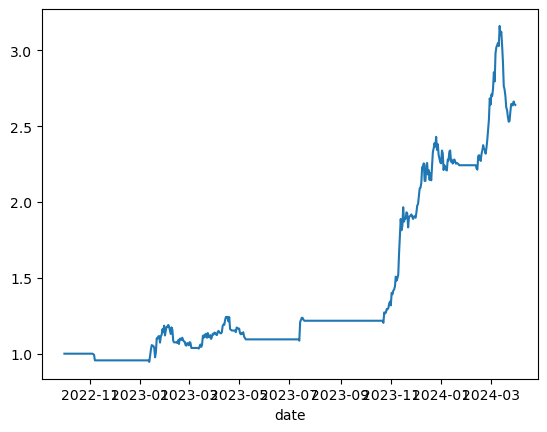

In [172]:
df_is_stop['equity_curve'].plot()

In [34]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'annualized_std_dev':['median','mean','std'],
            # 'vol_tracking_error':['median','mean','std'],
            'trade_count':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}